Line to Drive files for cell-phone dataset: https://drive.google.com/file/d/1ET7rXNa5vAhWNLK6YQsbuQsiQNavO2sL/view?usp=share_link

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Preprocessing ...

In [ ]:
import pandas as pd
import numpy as np
import torch
import json
import matplotlib.pyplot as plt
import os
import tqdm
import pickle
from pathlib import Path
from torch.utils.data import DataLoader
from sklearn.metrics import ndcg_score
np.random.seed(0)

In [ ]:
!wget https://jmcauley.ucsd.edu/data/amazon_v2/categoryFiles/Cell_Phones_and_Accessories.json.gz --no-check-certificate 

--2023-02-02 09:21:33--  https://jmcauley.ucsd.edu/data/amazon_v2/categoryFiles/Cell_Phones_and_Accessories.json.gz
Resolving jmcauley.ucsd.edu (jmcauley.ucsd.edu)... 137.110.160.73
Connecting to jmcauley.ucsd.edu (jmcauley.ucsd.edu)|137.110.160.73|:443... connected.
  Unable to locally verify the issuer's authority.
HTTP request sent, awaiting response... 200 OK
Length: 1232323281 (1.1G) [application/x-gzip]
Saving to: ‘Cell_Phones_and_Accessories.json.gz’

Cell_Phones_and_Acc 100%[===================>]   1.15G  45.0MB/s    in 27s     

2023-02-02 09:21:59 (44.3 MB/s) - ‘Cell_Phones_and_Accessories.json.gz’ saved [1232323281/1232323281]



In [ ]:
!gunzip Cell_Phones_and_Accessories.json.gz

In [ ]:
!wget https://jmcauley.ucsd.edu/data/amazon_v2/metaFiles2/meta_Cell_Phones_and_Accessories.json.gz --no-check-certificate 

--2023-02-02 09:22:39--  https://jmcauley.ucsd.edu/data/amazon_v2/metaFiles2/meta_Cell_Phones_and_Accessories.json.gz
Resolving jmcauley.ucsd.edu (jmcauley.ucsd.edu)... 137.110.160.73
Connecting to jmcauley.ucsd.edu (jmcauley.ucsd.edu)|137.110.160.73|:443... connected.
  Unable to locally verify the issuer's authority.
HTTP request sent, awaiting response... 200 OK
Length: 360006372 (343M) [application/x-gzip]
Saving to: ‘meta_Cell_Phones_and_Accessories.json.gz’

meta_Cell_Phones_an 100%[===================>] 343.33M  44.4MB/s    in 8.2s    

2023-02-02 09:22:48 (42.0 MB/s) - ‘meta_Cell_Phones_and_Accessories.json.gz’ saved [360006372/360006372]



In [ ]:
from nltk.corpus import stopwords
from nltk import word_tokenize
from nltk import FreqDist
import re
from nltk.tokenize import RegexpTokenizer
import nltk
from nltk.stem import WordNetLemmatizer
from nltk import word_tokenize,pos_tag
import pandas as pd

In [ ]:
sentires_dir='/content/drive/MyDrive/cell_phone/Cell_Phones_and_Accessories'
test_length=5
sample_ratio=2
val_length=1
neg_length=50
dataset='cell_phones'
save_path='/content/drive/MyDrive/cell_phone/'

In [ ]:
save_path='/content/drive/MyDrive/cell_phone/'

In [ ]:
df_review=pd.read_csv(save_path+'df_reviews.csv')

/usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py:3326: DtypeWarning: Columns (5) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [ ]:
df_meta=pd.read_csv(save_path+'df_meta.csv')

In [ ]:
import glob
items_list=[]
names=glob.glob(save_path+"description_bert/*.json")
for name in names:
  # items_dframe=pd.read_json(name)
  item_id=name.split('/')[-1].split('_')[-1][0:-5]
  items_list.append(item_id)


In [ ]:
len(items_list)

1940

In [ ]:
df_review.drop(df_review.index[~df_review['asin'].isin(items_list)], inplace=True) 

In [ ]:
df_review.drop('Unnamed: 0',axis=1,inplace=True)

In [ ]:
df_review.drop_duplicates(inplace=True)

In [ ]:
items_list1=[]
users_list=[]
review_features={}
f=open(save_path+'Cell_Phones_and_Accessories')
lines=f.readlines()
i=0
for line in lines:
  if i%5000==0:
    print(i)
  i+=1
  user_id = line.split('@')[0]
  item_id = line.split('@')[1]
  if item_id in items_list:
    users_list.append(user_id)
    items_list1.append(item_id)
    l = len(user_id) + len(item_id)
    fosr_data = line[l+3:]
    for seg in fosr_data.split('||'):
      if (user_id,item_id) not in review_features.keys():
        review_features[(user_id,item_id)]=[]
      fos = seg.split(':')[0].strip('|')
      if len(fos.split('|')) > 1:
          feature = fos.split('|')[0]
          opinion = fos.split('|')[1]
          sentiment = fos.split('|')[2]
          sentence= seg.split(':')[1]
          if sentiment=='+1':
            senti=1
          else:
            senti=-1
          review_features[(user_id,item_id)].append([feature,opinion,senti,sentence])

0
5000
10000
15000
20000
25000
30000
35000


In [ ]:
df_review=df_review[df_review.set_index(['reviewerID','asin']).index.isin(review_features.keys())]

In [ ]:
df_review

In [ ]:
def get_user_item_dict(df_review,items_list):
  user_dict = {}
  item_dict = {}
  i=0
  # removed_users=['A1ULCCHD1QNOS5','A1ZS098EKPVT8F','A1K1WK6I122RX2','A2PAFKGAUSBMIE','AAOYA0DKWED4W','AJS9Q2JYS3DLJ','ADOF1VKGDCBWF','A3G11XDKGXZT9Q','A1R233YLWSRBTC','A3VH9QMH2UTX9D','A15DZOS6KVANQH']    
  for index, row in df_review.iterrows():
    user=row['reviewerID']
    item=row['asin']
    if i%100000==0:
      print(i)
    i+=1
    if item in items_list:
      if user not in user_dict:
          user_dict[user] = [item]
      else:
          user_dict[user].append(item)
      if item not in item_dict:
          item_dict[item] = [user]
      else:
          item_dict[item].append(user)
  return user_dict,item_dict

In [ ]:
df_meta.loc[df_meta['feature'].str.len()<15]

In [ ]:
def get_normalized_rank(df_meta):
  ranks_dict={}
  for ind, row  in df_meta.iterrows():
    rank=row['rank']
    item_id=row['asin']
    numbers= rank.split('#')
    mean_rank=0
    count=0
    for num_text in numbers:
      if num_text.find(' ')>-1:
        num=float(num_text[0:num_text.find(' ')].replace(',',''))
        mean_rank+=num
        count+=1
    mean_rank/=(count)
    ranks_dict[item_id]=mean_rank
  minv=min(ranks_dict.values())
  maxv=max(ranks_dict.values())
  for k in ranks_dict:
    # print(ranks_dict[k])
    # print(minv)
    # print(maxv)
    ranks_dict[k] = (ranks_dict[k]-minv)/(maxv-minv)
  return ranks_dict

In [ ]:
import os

In [ ]:
def get_average_vect_train(df,not_in_columns):
  df['main_word']=np.where(df['replaced_word'] == df[not_in_columns],1,0)
  df=df[df['main_word']==1]
  lists=df.loc[:, ~df.columns.isin([not_in_columns,'replaced_word','logit','main_word'])].values
  words=df[not_in_columns].values
  # print(words)
  vects=[sub_list[0] for sub_list in lists]
  average=np.average(np.array(vects),axis=0)
  # print(words)
  # print(df)
  return average,list(words)

In [ ]:
def get_average_vect_test(weights,tensor_vect):
  # weights=torch.FloatTensor(weights).to(device)
  weights=torch.transpose(weights.repeat(tensor_vect.shape[1],1),0,1)
  average=torch.mean(weights*tensor_vect,axis=0).to(device)
  return average

In [ ]:
from typing_extensions import final
def get_item_matrix(item_name_dict,items_list):
  print('----- get items matrix -------')
  item_quality_matrix = np.zeros((len(item_name_dict), 2304))
  print((len(item_name_dict)))
  i=0
  features={}
  for item_id in items_list:
    if item_id in item_name_dict.keys():
      item=item_name_dict[item_id]
      features[item]=[]
      if i%100==0:
        print(i)
      i+=1
      final_vector=[]
      # print(item_id)
      df_vect_desc_item= pd.read_json(save_path+'description_bert/'+'df_bert_desc_{}.json'.format(item_id))
      df_vect_title_item= pd.read_json(save_path+'title_bert/'+'df_bert_title_{}.json'.format(item_id))
      df_vect_feature_item= pd.read_json(save_path+'feature_bert/'+'df_bert_feature_{}.json'.format(item_id))

      # print(item_id)
      # print(df_vect_desc_item)

      average_vect_desc,words_desc=get_average_vect_train(df_vect_desc_item,'description_words')
      average_vect_title,words_title=get_average_vect_train(df_vect_title_item,'title_words')
      average_vect_feature,words_feature=get_average_vect_train(df_vect_feature_item,'feature_words')

      features[item].append(words_desc)
      features[item].append(words_title)
      features[item].append(words_feature)
      # features[item].append(words_senti)
      # features[item].append([rank])
      final_vector=list(average_vect_desc)
      final_vector+=list(average_vect_title)
      final_vector+=list(average_vect_feature)
  # final_vector+=list(average_bert_sentiment)
  # final_vector+=[rank]
  
      if len(final_vector)>2304:
          print(len(list(average_vect_desc)))
          print(len(list(average_vect_title)))
          print(len(list(average_vect_feature)))
          # print(len(list(average_bert_sentiment)))
          print(item_id)
      item_quality_matrix[item]=final_vector
      # print(item_quality_matrix)

  item_quality_matrix = np.array(item_quality_matrix, dtype='float32')
  return item_quality_matrix,features

In [ ]:
def get_user_matrix(item_matrix,inv_user_name_dict,item_name_dict):
  user_quality_matrix = np.zeros((len(inv_user_name_dict), 2304))
  i=0
  print('----- get users matrix -------')
  print((len(inv_user_name_dict)))
  for  user in inv_user_name_dict.keys():
    if i%1000==0:
      print(i)
    i+=1
    user_id= inv_user_name_dict[user]
    final_vector=[]
    items_interacted=df_review[df_review['reviewerID']==user_id ]
    # mean_rate=np.average(items_interacted['overall'].values)
    # weights=[]
    for item_id in items_interacted['asin'].values:
      if item_id in item_name_dict.keys():
        item=item_name_dict[item_id]
        # weight=items_interacted[items_interacted['asin']==item_id]['overall'].values[0]-mean_rate
        # weights.append(weight)
        final_vector.append(item_matrix[item])
    # if np.sum(weights)>0 or np.sum(weights)<0:
    #   final_average=np.average(final_vector,weights=weights,axis=0)
    # else:
    final_average=np.average(final_vector,axis=0)
    if ~np.isnan(np.sum(final_average)):
      user_quality_matrix[user]=final_average
    else:
      print(user_id)
  user_quality_matrix = np.array(user_quality_matrix, dtype='float32')
  return user_quality_matrix

In [ ]:
def sample_training_pairs(user, training_items, item_set, sample_ratio=10):
    positive_items = set(training_items)
    negative_items = set()
    for item in item_set:
        if item not in positive_items:
            negative_items.add(item)
    neg_length = len(positive_items) * sample_ratio
    negative_items = np.random.choice(np.array(list(negative_items)), neg_length, replace=False)
    train_pairs = []
    for p_item in positive_items:
        train_pairs.append([user, p_item, 1])
    for n_item in negative_items:
        train_pairs.append([user, n_item, 0])
    return train_pairs

In [ ]:
import glob
def get_items_list():
  items_list=[]
  names=glob.glob(save_path+"title_bert/*.json")
  for name in names:
    items_list.append(name.split('/')[-1].split('_')[-1][0:-5])
  return items_list

In [ ]:
from re import S
import torch
import numpy as np
import json
import pickle
# from torch._C import R
import tqdm
from torch.random import seed


class AmazonDataset():
    def __init__(self):
        super().__init__()

        self.user_name_dict = {}  # rename users to integer names
        self.item_name_dict = {}
        self.feature_name_dict = {}

        self.features = {}  # feature list
        self.users = []
        self.items = []

        # the interacted items for each user, sorted with date {user:[i1, i2, i3, ...], user:[i1, i2, i3, ...]}
        self.user_hist_inter_dict = {}
        # the interacted users for each item
        self.item_hist_inter_dict = {}  

        self.user_num = None
        self.item_num = None
        self.feature_num = 2304# number of features

        self.user_feature_matrix = None  # user aspect attention matrix
        self.item_feature_matrix = None  # item aspect quality matrix

        self.training_data = None
        self.test_data = None
        self.pre_processing()
        self.get_user_item_feature_matrix()
        self.sample_training()  # sample training data, for traning BPR loss
        self.sample_test()  # sample test data

    def pre_processing(self,):
        self.items_list=get_items_list()
        user_dict, item_dict = get_user_item_dict(df_review,self.items_list)  # not sorted with time
        print(len(item_dict))
        user_item_date_dict = {}   # {(user, item): date, (user, item): date ...}  # used to remove duplicate
        # removed_users=['A1ULCCHD1QNOS5','A1ZS098EKPVT8F','A1K1WK6I122RX2','A2PAFKGAUSBMIE','AAOYA0DKWED4W','AJS9Q2JYS3DLJ','ADOF1VKGDCBWF','A3G11XDKGXZT9Q','A1R233YLWSRBTC','A3VH9QMH2UTX9D','A15DZOS6KVANQH']
        for i, row in df_review.iterrows():
            user = row['reviewerID']
            item = row['asin']
            date = row['unixReviewTime']
            if item in self.items_list:
                if user in user_dict and item in user_dict[user] and (user, item) not in user_item_date_dict:
                    user_item_date_dict[(user, item)] = date
        
        # rename users, items, and features to integer names
        user_name_dict = {}
        item_name_dict = {}
        # feature_name_dict = {}
        # features = get_feature_list(df_bert_sentiment,df_bert_desc,)
        
        count = 0
        for user in user_dict:
            if user not in user_name_dict:
                user_name_dict[user] = count
                count += 1
        count = 0
        for item in item_dict:
            if item not in item_name_dict:
                item_name_dict[item] = count
                count += 1
        self.inv_user_name_dict = {v: k for k, v in user_name_dict.items()}
        self.inv_item_name_dict = {v: k for k, v in item_name_dict.items()}
        
        # for i in range(len(sentiment_data)):
        #     sentiment_data[i][0] = user_name_dict[sentiment_data[i][0]]
        #     sentiment_data[i][1] = item_name_dict[sentiment_data[i][1]]
        #     for j in range(len(sentiment_data[i]) - 2):
        #         sentiment_data[i][j+2][0] = feature_name_dict[sentiment_data[i][j + 2][0]]

        renamed_user_item_date_dict = {}
        for key, value in user_item_date_dict.items():
            renamed_user_item_date_dict[user_name_dict[key[0]], item_name_dict[key[1]]] = value

        # sort with date
        renamed_user_item_date_dict  = dict(sorted(renamed_user_item_date_dict .items(), key=lambda item: item[1]))

        user_hist_inter_dict = {}  # {"u1": [i1, i2, i3, ...], "u2": [i1, i2, i3, ...]}, sort with time
        item_hist_inter_dict = {}
        # ranked_user_item_dict = {}  # {"u1": [i1, i2, i3, ...], "u2": [i1, i2, i3, ...]}
        for key, value in renamed_user_item_date_dict.items():
            user = key[0]
            item = key[1]
            if user not in user_hist_inter_dict:
                user_hist_inter_dict[user] = [item]
            else:
                user_hist_inter_dict[user].append(item)
            if item not in item_hist_inter_dict:
                item_hist_inter_dict[item] = [user]
            else:
                item_hist_inter_dict[item].append(user)

        user_hist_inter_dict = dict(sorted(user_hist_inter_dict.items()))
        item_hist_inter_dict = dict(sorted(item_hist_inter_dict.items()))

        users = list(user_hist_inter_dict.keys())
        items = list(item_hist_inter_dict.keys())

        self.user_name_dict = user_name_dict
        self.item_name_dict = item_name_dict
        self.user_hist_inter_dict = user_hist_inter_dict
        self.item_hist_inter_dict = item_hist_inter_dict
        self.users = users
        self.items = items
        self.user_num = len(users)
        self.item_num = len(items)
        return True
    
    def get_user_item_feature_matrix(self,):
        # exclude test data from the sentiment data to construct matrix
        train_u_i_set = set()
        for user, items in self.user_hist_inter_dict.items():
            items = items[:-test_length]
            for item in items:
                train_u_i_set.add((user, item))

        self.item_feature_matrix,self.item_features= get_item_matrix(self.item_name_dict,self.items_list)
        self.user_feature_matrix = get_user_matrix(self.item_feature_matrix,self.inv_user_name_dict,self.item_name_dict)
        
        return True
    
    def sample_training(self):
        print('======================= sample training data =======================')
        training_data = []
        training_pairs = np.loadtxt(save_path+'training_data.txt',dtype=str)
        for pair in training_pairs:
          # print(self.user_name_dict)
          # print(pair[0])
          if pair[0] in self.user_name_dict.keys() and pair[1] in self.item_name_dict.keys():
            training_data.append([self.user_name_dict[pair[0]],self.item_name_dict[pair[1]],int(pair[2])])


        # print(self.user_feature_matrix.shape, self.item_feature_matrix.shape)
        # training_data = []
        # item_set = set(self.items)
        # for user, items in self.user_hist_inter_dict.items():
        #     if len(items)>15:
        #       items = items[:-(test_length)]
        #       training_pairs = sample_training_pairs(
        #           user, 
        #           items, 
        #           item_set, 
        #           sample_ratio)
        #       for pair in training_pairs:
        #           training_data.append(pair)
        print('# training samples :', len(training_data))
        self.training_data = np.array(training_data)
      
        return True
    
    def sample_test(self):
        print('======================= sample test data =======================')
        user_item_label_list = []  # [[u, [item1, item2, ...], [l1, l2, ...]], ...]
        with open(save_path+'test_data.pickle', 'rb') as f:
            test_pairs= pickle.load(f)
        for user_id in test_pairs.keys():
          user=self.user_name_dict[user_id]
          items_ids=test_pairs[user_id][0]
          labels=test_pairs[user_id][1]
          items=np.array([self.item_name_dict[item] for item in items_ids if item in self.item_name_dict])
          labels=np.array([float(labels[i]) for i in range(len(labels)) if items_ids[i] in self.item_name_dict])
          user_item_label_list.append([user,items,labels])
        print('# test samples :', len(user_item_label_list))
        self.test_data = np.array(user_item_label_list)

        # validation_data = []  # [[u, [item1, item2, ...], [l1, l2, ...]], ...]
        # with open(save_path+'validation_data.pickle', 'rb') as f:
        #     validation_pairs= pickle.load(f)
        # for user_id in validation_pairs.keys():
        #   user=self.user_name_dict[user_id]
        #   items_ids=validation_pairs[user_id][0]
        #   labels=validation_pairs[user_id][1]
        #   items=np.array([self.item_name_dict[item] for item in items_ids if item in self.item_name_dict])
        #   labels=np.array([float(labels[i]) for i in range(len(labels)) if items_ids[i] in self.item_name_dict])
        #   validation_data.append([user,items,labels])
        # print('# validation samples :', len(validation_data))
        # self.validation_data = np.array(validation_data)


        # user_item_label_list = []  # [[u, [item1, item2, ...], [l1, l2, ...]], ...]
        # validation_data=[]
        # for user, items in self.user_hist_inter_dict.items():
        #   if len(items)>15:
        #     # print(items)
        #     items1 = items[-(test_length):-(val_length)]
        #     items2 = items[-(val_length):]
        #     # print(items1)
        #     # print(items2)
        #     user_item_label_list.append([user, items1, np.ones(len(items1))])  # add the test items
        #     validation_data.append([user, items2, np.ones(len(items2))])
        #     neg_length1=len(items1)*5
        #     neg_length2=len(items2)*5
        #     negative_items1 = [item for item in self.items if 
        #         item not in self.user_hist_inter_dict[user]]  # the not interacted items
        #     # print(len(negative_items1))
        #     negative_items1 = np.random.choice(np.array(negative_items1), neg_length1, replace=False)
        #     negative_items2 = np.random.choice(np.array(negative_items1), neg_length2, replace=False)

        #     user_item_label_list[-1][1] = np.concatenate((user_item_label_list[-1][1], negative_items1), axis=0)
        #     user_item_label_list[-1][2] = np.concatenate((user_item_label_list[-1][2], np.zeros(neg_length1)), axis=0)

        #     validation_data[-1][1] = np.concatenate((validation_data[-1][1], negative_items2), axis=0)
        #     validation_data[-1][2] = np.concatenate((validation_data[-1][2], np.zeros(neg_length2)), axis=0)
        # print('# test samples :', len(user_item_label_list))
        # print('# validation samples :', len(validation_data))
        # self.test_data = np.array(user_item_label_list)
        # self.validation_data=np.array(validation_data)
        return True

    def save(self, save_path):
        return True
    
    def load(self):
        return False

In [ ]:
user_item_label_list

In [ ]:
def amazon_preprocessing():
    rec_dataset = AmazonDataset()
    return rec_dataset

In [ ]:
def dataset_init():
	if dataset == "yelp":
		rec_dataset = yelp_preprocessing()
	elif dataset == "cell_phones" or "kindle_store" or "electronic" or "cds_and_vinyl":
		rec_dataset = amazon_preprocessing()
	return rec_dataset

In [ ]:
dataset="cell_phones"
gpu=True
cuda='0'
weight_decay=0.00001
lr=0.005
epochs=500
batch_size=64
rec_k=5

In [ ]:
import numpy as np
from torch.utils.data import Dataset
class UserItemInterDataset(Dataset):
    def __init__(self, data, user_feature_matrix, item_feature_matrix):
        self.data = data
        self.user_feature_matrix = user_feature_matrix
        self.item_feature_matrix = item_feature_matrix

    def __getitem__(self, index):
        user = self.data[index][0]
        item = self.data[index][1]
        label = self.data[index][2]
        user_feature = self.user_feature_matrix[user]
        item_feature = self.item_feature_matrix[item]
        return user_feature, item_feature, label
    def __len__(self):
        return len(self.data)

# Train Black-box Model ...


In [ ]:
import numpy as np
import torch
from sklearn.metrics import ndcg_score

In [ ]:
def compute_ndcg(test_data, user_feature_matrix, item_feature_matrix, k, model, device):
    model.eval()
    ndcgs = []
    with torch.no_grad():
        for row in test_data:
            user = row[0]
            items = row[1]
            gt_labels = row[2]
            user_features = np.array([user_feature_matrix[user] for i in range(len(items))])
            item_features = np.array([item_feature_matrix[item] for item in items])
            scores = model(torch.from_numpy(user_features).to(device),
                                    torch.from_numpy(item_features).to(device)).squeeze()
            scores = np.array(scores.to('cpu'))
            ndcg = ndcg_score([gt_labels], [scores], k=k)
            ndcgs.append(ndcg)
    ave_ndcg = np.mean(ndcgs)
    return ave_ndcg


In [ ]:
import torch
import numpy as np
import os
import tqdm
import pickle
from pathlib import Path
from torch.utils.data import DataLoader

In [ ]:
from numpy import core

class BaseRecModel(torch.nn.Module):
    def __init__(self, feature_length):
        super(BaseRecModel, self).__init__()
        self.fc = torch.nn.Sequential(
            torch.nn.Linear(feature_length * 2, 512),
            torch.nn.ReLU(),
            torch.nn.Linear(512, 256),
            torch.nn.ReLU(),
            torch.nn.Linear(256, 1),
            torch.nn.Sigmoid()
        )

    def forward(self, user_feature, item_feature):
        fusion = torch.cat((user_feature, item_feature), 1)
        out = self.fc(fusion)
        return out


In [ ]:
if gpu:
  device = torch.device('cuda:%s' % cuda)
else:
  device = 'cpu'
print(device)

cuda:0


In [ ]:
rec_dataset = dataset_init()

0
1940
----- get items matrix -------
1940
0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
----- get users matrix -------
6783
0
1000
2000
3000
4000
5000
6000
======================= sample training data =======================
# training samples : 2858
======================= sample test data =======================
# test samples : 93


<ipython-input-59-47ccbcb18f4a>:174: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  self.test_data = np.array(user_item_label_list)


In [ ]:
 Path(save_path).mkdir(parents=True, exist_ok=True)
 with open(os.path.join(save_path,dataset + "_dataset_obj.pickle"), 'wb') as outp:
        pickle.dump(rec_dataset, outp, pickle.HIGHEST_PROTOCOL)

In [ ]:
with open(os.path.join(save_path, dataset + "_dataset_obj.pickle"), 'rb') as inp:
  rec_dataset = pickle.load(inp)

In [ ]:
training_data=[]
for train_data in rec_dataset.training_data:
  user=train_data[0]
  item=train_data[1]
  label=train_data[2]
  user_id=rec_dataset.inv_user_name_dict[user]
  item_id=rec_dataset.inv_item_name_dict[item]
  training_data.append([user_id,item_id,label])

In [ ]:
np.savetxt('training_data.txt', training_data, fmt='%s')
b = np.loadtxt('training_data.txt',dtype=str)

In [ ]:
import pickle
pet_stats = {'name':"", 'int':1, 'bool':False}

def pet_save(pet,name):
    with open('{}_data.pickle'.format(name), 'wb') as f:
        pickle.dump(pet, f, pickle.HIGHEST_PROTOCOL)

def digimon_load():
    with open('test_data.pickle', 'rb') as f:
        return pickle.load(f)

In [ ]:
testing_data={}
for ts_data in rec_dataset.test_data:
  user=ts_data[0]
  items=ts_data[1]
  labels=ts_data[2]
  # print(user , item, label)
  user_id=rec_dataset.inv_user_name_dict[user]
  items_id=[rec_dataset.inv_item_name_dict[item] for item in items]
  testing_data[user_id]=[items_id,labels]

In [ ]:
pet_save(testing_data,'test')

In [ ]:
import matplotlib.pyplot as plt

Using CUDA 0
init ndcg: 0.09603078199016701


  0%|          | 0/500 [00:00<?, ?it/s]

epoch 0:  training loss:  0.67331594


  0%|          | 1/500 [00:00<02:28,  3.36it/s]

epoch 0:  training loss:  0.67331594 NDCG_validation:  0.07678337265764436


  0%|          | 2/500 [00:00<01:38,  5.04it/s]

epoch 1:  training loss:  0.64971954


  1%|          | 3/500 [00:00<01:21,  6.10it/s]

epoch 2:  training loss:  0.6400992


  1%|          | 4/500 [00:00<01:12,  6.83it/s]

epoch 3:  training loss:  0.636355


  1%|          | 5/500 [00:00<01:08,  7.23it/s]

epoch 4:  training loss:  0.63443226


  1%|          | 6/500 [00:00<01:05,  7.51it/s]

epoch 5:  training loss:  0.63443


  1%|▏         | 7/500 [00:01<01:03,  7.75it/s]

epoch 6:  training loss:  0.63401186


  2%|▏         | 8/500 [00:01<01:01,  7.98it/s]

epoch 7:  training loss:  0.6327359


  2%|▏         | 9/500 [00:01<01:02,  7.86it/s]

epoch 8:  training loss:  0.6325523


  2%|▏         | 10/500 [00:01<01:02,  7.79it/s]

epoch 9:  training loss:  0.6326231
epoch 10:  training loss:  0.632245


  2%|▏         | 11/500 [00:01<01:18,  6.22it/s]

epoch 10:  training loss:  0.632245 NDCG_validation:  0.20439825068811532


  2%|▏         | 12/500 [00:01<01:12,  6.69it/s]

epoch 11:  training loss:  0.6313473


  3%|▎         | 13/500 [00:01<01:08,  7.13it/s]

epoch 12:  training loss:  0.6316836


  3%|▎         | 14/500 [00:02<01:04,  7.50it/s]

epoch 13:  training loss:  0.63063


  3%|▎         | 15/500 [00:02<01:02,  7.70it/s]

epoch 14:  training loss:  0.6306069


  3%|▎         | 16/500 [00:02<01:01,  7.92it/s]

epoch 15:  training loss:  0.62961996


  3%|▎         | 17/500 [00:02<01:01,  7.90it/s]

epoch 16:  training loss:  0.6296974


  4%|▎         | 18/500 [00:02<00:59,  8.09it/s]

epoch 17:  training loss:  0.62910163


  4%|▍         | 19/500 [00:02<00:58,  8.17it/s]

epoch 18:  training loss:  0.6285865


  4%|▍         | 20/500 [00:02<00:58,  8.21it/s]

epoch 19:  training loss:  0.62821305
epoch 20:  training loss:  0.6273433


  4%|▍         | 21/500 [00:02<01:15,  6.36it/s]

epoch 20:  training loss:  0.6273433 NDCG_validation:  0.20632590079572452


  4%|▍         | 22/500 [00:03<01:09,  6.84it/s]

epoch 21:  training loss:  0.6268001


  5%|▍         | 23/500 [00:03<01:05,  7.26it/s]

epoch 22:  training loss:  0.62590086


  5%|▍         | 24/500 [00:03<01:04,  7.43it/s]

epoch 23:  training loss:  0.625171


  5%|▌         | 25/500 [00:03<01:01,  7.71it/s]

epoch 24:  training loss:  0.62494653


  5%|▌         | 26/500 [00:03<01:00,  7.89it/s]

epoch 25:  training loss:  0.62380093


  5%|▌         | 27/500 [00:03<00:59,  8.00it/s]

epoch 26:  training loss:  0.6232139


  6%|▌         | 28/500 [00:03<00:58,  8.01it/s]

epoch 27:  training loss:  0.6226231


  6%|▌         | 29/500 [00:03<00:58,  7.98it/s]

epoch 28:  training loss:  0.6225164


  6%|▌         | 30/500 [00:04<00:57,  8.11it/s]

epoch 29:  training loss:  0.6208027
epoch 30:  training loss:  0.62038696


  6%|▌         | 31/500 [00:04<01:13,  6.39it/s]

epoch 30:  training loss:  0.62038696 NDCG_validation:  0.2187892308511606


  6%|▋         | 32/500 [00:04<01:08,  6.79it/s]

epoch 31:  training loss:  0.61983013


  7%|▋         | 33/500 [00:04<01:05,  7.09it/s]

epoch 32:  training loss:  0.6181537


  7%|▋         | 34/500 [00:04<01:02,  7.45it/s]

epoch 33:  training loss:  0.6174254


  7%|▋         | 35/500 [00:04<01:00,  7.64it/s]

epoch 34:  training loss:  0.6166035


  7%|▋         | 36/500 [00:04<00:58,  7.87it/s]

epoch 35:  training loss:  0.61560893


  7%|▋         | 37/500 [00:05<00:57,  8.06it/s]

epoch 36:  training loss:  0.61537766


  8%|▊         | 38/500 [00:05<00:57,  8.07it/s]

epoch 37:  training loss:  0.6138488


  8%|▊         | 39/500 [00:05<00:57,  8.07it/s]

epoch 38:  training loss:  0.612393


  8%|▊         | 40/500 [00:05<00:57,  8.03it/s]

epoch 39:  training loss:  0.6120976
epoch 40:  training loss:  0.6102229


  8%|▊         | 41/500 [00:05<01:12,  6.32it/s]

epoch 40:  training loss:  0.6102229 NDCG_validation:  0.2296240383530465


  8%|▊         | 42/500 [00:05<01:07,  6.82it/s]

epoch 41:  training loss:  0.6087767


  9%|▊         | 43/500 [00:05<01:03,  7.16it/s]

epoch 42:  training loss:  0.60753316


  9%|▉         | 44/500 [00:06<01:01,  7.44it/s]

epoch 43:  training loss:  0.60594267


  9%|▉         | 45/500 [00:06<00:59,  7.68it/s]

epoch 44:  training loss:  0.60488707


  9%|▉         | 46/500 [00:06<00:57,  7.86it/s]

epoch 45:  training loss:  0.6037908


  9%|▉         | 47/500 [00:06<00:56,  8.02it/s]

epoch 46:  training loss:  0.6026032


 10%|▉         | 48/500 [00:06<00:56,  8.01it/s]

epoch 47:  training loss:  0.60075325


 10%|▉         | 49/500 [00:06<00:55,  8.16it/s]

epoch 48:  training loss:  0.59826195


 10%|█         | 50/500 [00:06<00:55,  8.05it/s]

epoch 49:  training loss:  0.5985606
epoch 50:  training loss:  0.59664506


 10%|█         | 51/500 [00:06<01:12,  6.16it/s]

epoch 50:  training loss:  0.59664506 NDCG_validation:  0.24021237537032566


 10%|█         | 52/500 [00:07<01:07,  6.63it/s]

epoch 51:  training loss:  0.594649


 11%|█         | 53/500 [00:07<01:02,  7.10it/s]

epoch 52:  training loss:  0.59328336


 11%|█         | 54/500 [00:07<01:00,  7.41it/s]

epoch 53:  training loss:  0.5918943


 11%|█         | 55/500 [00:07<00:59,  7.51it/s]

epoch 54:  training loss:  0.58965653


 11%|█         | 56/500 [00:07<00:57,  7.73it/s]

epoch 55:  training loss:  0.58889896


 11%|█▏        | 57/500 [00:07<00:55,  7.91it/s]

epoch 56:  training loss:  0.5876808


 12%|█▏        | 58/500 [00:07<00:55,  7.95it/s]

epoch 57:  training loss:  0.586562


 12%|█▏        | 59/500 [00:07<00:54,  8.10it/s]

epoch 58:  training loss:  0.58447814


 12%|█▏        | 60/500 [00:08<00:53,  8.18it/s]

epoch 59:  training loss:  0.5824943
epoch 60:  training loss:  0.5809355


 12%|█▏        | 61/500 [00:08<01:07,  6.51it/s]

epoch 60:  training loss:  0.5809355 NDCG_validation:  0.24376843837038992


 12%|█▏        | 62/500 [00:08<01:03,  6.94it/s]

epoch 61:  training loss:  0.57940114


 13%|█▎        | 63/500 [00:08<01:00,  7.24it/s]

epoch 62:  training loss:  0.5785089


 13%|█▎        | 64/500 [00:08<00:57,  7.55it/s]

epoch 63:  training loss:  0.5760915


 13%|█▎        | 65/500 [00:08<00:55,  7.82it/s]

epoch 64:  training loss:  0.5747853


 13%|█▎        | 66/500 [00:08<00:54,  7.90it/s]

epoch 65:  training loss:  0.5728823


 13%|█▎        | 67/500 [00:09<00:53,  8.03it/s]

epoch 66:  training loss:  0.5707316


 14%|█▎        | 68/500 [00:09<00:53,  8.02it/s]

epoch 67:  training loss:  0.5708262


 14%|█▍        | 69/500 [00:09<00:52,  8.15it/s]

epoch 68:  training loss:  0.56751424


 14%|█▍        | 70/500 [00:09<00:52,  8.22it/s]

epoch 69:  training loss:  0.5673572
epoch 70:  training loss:  0.565911


 14%|█▍        | 71/500 [00:09<01:07,  6.35it/s]

epoch 70:  training loss:  0.565911 NDCG_validation:  0.24366139997596387


 14%|█▍        | 72/500 [00:09<01:02,  6.82it/s]

epoch 71:  training loss:  0.5638665


 15%|█▍        | 73/500 [00:09<00:58,  7.25it/s]

epoch 72:  training loss:  0.56247085


 15%|█▍        | 74/500 [00:09<00:56,  7.50it/s]

epoch 73:  training loss:  0.5614668


 15%|█▌        | 75/500 [00:10<00:54,  7.77it/s]

epoch 74:  training loss:  0.55939037


 15%|█▌        | 76/500 [00:10<00:53,  7.91it/s]

epoch 75:  training loss:  0.55839866


 15%|█▌        | 77/500 [00:10<00:52,  8.09it/s]

epoch 76:  training loss:  0.5552417


 16%|█▌        | 78/500 [00:10<00:52,  8.11it/s]

epoch 77:  training loss:  0.5541752


 16%|█▌        | 79/500 [00:10<00:51,  8.17it/s]

epoch 78:  training loss:  0.5535868


 16%|█▌        | 80/500 [00:10<00:52,  8.02it/s]

epoch 79:  training loss:  0.5531768
epoch 80:  training loss:  0.5506551


 16%|█▌        | 81/500 [00:10<01:08,  6.16it/s]

epoch 80:  training loss:  0.5506551 NDCG_validation:  0.24822467412320545


 16%|█▋        | 82/500 [00:11<01:02,  6.68it/s]

epoch 81:  training loss:  0.54805


 17%|█▋        | 83/500 [00:11<00:58,  7.09it/s]

epoch 82:  training loss:  0.5460423


 17%|█▋        | 84/500 [00:11<00:56,  7.38it/s]

epoch 83:  training loss:  0.5457518


 17%|█▋        | 85/500 [00:11<00:54,  7.64it/s]

epoch 84:  training loss:  0.5433556


 17%|█▋        | 86/500 [00:11<00:53,  7.67it/s]

epoch 85:  training loss:  0.5421493


 17%|█▋        | 87/500 [00:11<00:52,  7.84it/s]

epoch 86:  training loss:  0.540305


 18%|█▊        | 88/500 [00:11<00:51,  8.02it/s]

epoch 87:  training loss:  0.538231


 18%|█▊        | 89/500 [00:11<00:50,  8.11it/s]

epoch 88:  training loss:  0.53699243


 18%|█▊        | 90/500 [00:12<00:49,  8.22it/s]

epoch 89:  training loss:  0.5354919
epoch 90:  training loss:  0.5338419


 18%|█▊        | 91/500 [00:12<01:03,  6.45it/s]

epoch 90:  training loss:  0.5338419 NDCG_validation:  0.27938127217229114


 18%|█▊        | 92/500 [00:12<00:59,  6.89it/s]

epoch 91:  training loss:  0.531743


 19%|█▊        | 93/500 [00:12<00:56,  7.25it/s]

epoch 92:  training loss:  0.52904487


 19%|█▉        | 94/500 [00:12<00:53,  7.60it/s]

epoch 93:  training loss:  0.52748954


 19%|█▉        | 95/500 [00:12<00:52,  7.78it/s]

epoch 94:  training loss:  0.5262797


 19%|█▉        | 96/500 [00:12<00:51,  7.92it/s]

epoch 95:  training loss:  0.52626723


 19%|█▉        | 97/500 [00:13<00:49,  8.07it/s]

epoch 96:  training loss:  0.5211602


 20%|█▉        | 98/500 [00:13<00:48,  8.21it/s]

epoch 97:  training loss:  0.5196688


 20%|█▉        | 99/500 [00:13<00:48,  8.28it/s]

epoch 98:  training loss:  0.51927483


 20%|██        | 100/500 [00:13<00:48,  8.29it/s]

epoch 99:  training loss:  0.51612246
epoch 100:  training loss:  0.51543903


 20%|██        | 101/500 [00:13<01:01,  6.52it/s]

epoch 100:  training loss:  0.51543903 NDCG_validation:  0.2929987229302398


 20%|██        | 102/500 [00:13<00:57,  6.97it/s]

epoch 101:  training loss:  0.5135557


 21%|██        | 103/500 [00:13<00:54,  7.35it/s]

epoch 102:  training loss:  0.51280487


 21%|██        | 104/500 [00:13<00:52,  7.60it/s]

epoch 103:  training loss:  0.5117483


 21%|██        | 105/500 [00:14<00:50,  7.84it/s]

epoch 104:  training loss:  0.509035


 21%|██        | 106/500 [00:14<00:49,  7.99it/s]

epoch 105:  training loss:  0.5060008


 21%|██▏       | 107/500 [00:14<00:49,  7.99it/s]

epoch 106:  training loss:  0.5056761


 22%|██▏       | 108/500 [00:14<00:48,  8.11it/s]

epoch 107:  training loss:  0.502044


 22%|██▏       | 109/500 [00:14<00:48,  8.09it/s]

epoch 108:  training loss:  0.49894688


 22%|██▏       | 110/500 [00:14<00:47,  8.23it/s]

epoch 109:  training loss:  0.49813852
epoch 110:  training loss:  0.49447513


 22%|██▏       | 111/500 [00:14<01:00,  6.42it/s]

epoch 110:  training loss:  0.49447513 NDCG_validation:  0.29837246620812313


 22%|██▏       | 112/500 [00:15<00:56,  6.82it/s]

epoch 111:  training loss:  0.4953227


 23%|██▎       | 113/500 [00:15<00:53,  7.23it/s]

epoch 112:  training loss:  0.49378225


 23%|██▎       | 114/500 [00:15<00:50,  7.58it/s]

epoch 113:  training loss:  0.4922606


 23%|██▎       | 115/500 [00:15<00:48,  7.86it/s]

epoch 114:  training loss:  0.4937913


 23%|██▎       | 116/500 [00:15<00:47,  8.04it/s]

epoch 115:  training loss:  0.48606083


 23%|██▎       | 117/500 [00:15<00:47,  8.11it/s]

epoch 116:  training loss:  0.4858741


 24%|██▎       | 118/500 [00:15<00:46,  8.20it/s]

epoch 117:  training loss:  0.4812268


 24%|██▍       | 119/500 [00:15<00:45,  8.32it/s]

epoch 118:  training loss:  0.4809554


 24%|██▍       | 120/500 [00:16<00:46,  8.21it/s]

epoch 119:  training loss:  0.47768566
epoch 120:  training loss:  0.4777643


 24%|██▍       | 121/500 [00:16<00:58,  6.46it/s]

epoch 120:  training loss:  0.4777643 NDCG_validation:  0.30348533566444724


 24%|██▍       | 122/500 [00:16<00:55,  6.81it/s]

epoch 121:  training loss:  0.47472933


 25%|██▍       | 123/500 [00:16<00:52,  7.23it/s]

epoch 122:  training loss:  0.46886796


 25%|██▍       | 124/500 [00:16<00:50,  7.43it/s]

epoch 123:  training loss:  0.4692736


 25%|██▌       | 125/500 [00:16<00:48,  7.72it/s]

epoch 124:  training loss:  0.46634233


 25%|██▌       | 126/500 [00:16<00:46,  7.96it/s]

epoch 125:  training loss:  0.4623884


 25%|██▌       | 127/500 [00:16<00:45,  8.11it/s]

epoch 126:  training loss:  0.4660242


 26%|██▌       | 128/500 [00:17<00:44,  8.27it/s]

epoch 127:  training loss:  0.4621805


 26%|██▌       | 129/500 [00:17<00:45,  8.22it/s]

epoch 128:  training loss:  0.4609323


 26%|██▌       | 130/500 [00:17<00:45,  8.16it/s]

epoch 129:  training loss:  0.45893428
epoch 130:  training loss:  0.45764273


 26%|██▌       | 131/500 [00:17<00:57,  6.47it/s]

epoch 130:  training loss:  0.45764273 NDCG_validation:  0.318473366589751


 26%|██▋       | 132/500 [00:17<00:53,  6.89it/s]

epoch 131:  training loss:  0.46334404


 27%|██▋       | 133/500 [00:17<00:50,  7.27it/s]

epoch 132:  training loss:  0.45047078


 27%|██▋       | 134/500 [00:17<00:48,  7.53it/s]

epoch 133:  training loss:  0.45100504


 27%|██▋       | 135/500 [00:18<00:46,  7.77it/s]

epoch 134:  training loss:  0.44866434


 27%|██▋       | 136/500 [00:18<00:45,  8.00it/s]

epoch 135:  training loss:  0.44695273


 27%|██▋       | 137/500 [00:18<00:44,  8.17it/s]

epoch 136:  training loss:  0.44151446


 28%|██▊       | 138/500 [00:18<00:43,  8.26it/s]

epoch 137:  training loss:  0.4406968


 28%|██▊       | 139/500 [00:18<00:43,  8.27it/s]

epoch 138:  training loss:  0.439856


 28%|██▊       | 140/500 [00:18<00:44,  8.11it/s]

epoch 139:  training loss:  0.43939507
epoch 140:  training loss:  0.44629753


 28%|██▊       | 141/500 [00:18<00:55,  6.46it/s]

epoch 140:  training loss:  0.44629753 NDCG_validation:  0.3158770649516542


 28%|██▊       | 142/500 [00:18<00:52,  6.81it/s]

epoch 141:  training loss:  0.4344292


 29%|██▊       | 143/500 [00:19<00:49,  7.23it/s]

epoch 142:  training loss:  0.43107426


 29%|██▉       | 144/500 [00:19<00:47,  7.49it/s]

epoch 143:  training loss:  0.4307112


 29%|██▉       | 145/500 [00:19<00:45,  7.73it/s]

epoch 144:  training loss:  0.4327869


 29%|██▉       | 146/500 [00:19<00:44,  7.89it/s]

epoch 145:  training loss:  0.43200895


 29%|██▉       | 147/500 [00:19<00:43,  8.05it/s]

epoch 146:  training loss:  0.43353182


 30%|██▉       | 148/500 [00:19<00:45,  7.82it/s]

epoch 147:  training loss:  0.43306252


 30%|██▉       | 149/500 [00:19<00:44,  7.83it/s]

epoch 148:  training loss:  0.41882885


 30%|███       | 150/500 [00:19<00:44,  7.88it/s]

epoch 149:  training loss:  0.42166498
epoch 150:  training loss:  0.42172214


 30%|███       | 151/500 [00:20<00:55,  6.31it/s]

epoch 150:  training loss:  0.42172214 NDCG_validation:  0.3356190298478168


 30%|███       | 152/500 [00:20<00:51,  6.71it/s]

epoch 151:  training loss:  0.41882768


 31%|███       | 153/500 [00:20<00:48,  7.14it/s]

epoch 152:  training loss:  0.41859248


 31%|███       | 154/500 [00:20<00:46,  7.51it/s]

epoch 153:  training loss:  0.419222


 31%|███       | 155/500 [00:20<00:44,  7.70it/s]

epoch 154:  training loss:  0.41483957


 31%|███       | 156/500 [00:20<00:43,  7.92it/s]

epoch 155:  training loss:  0.418373


 31%|███▏      | 157/500 [00:20<00:42,  8.05it/s]

epoch 156:  training loss:  0.40870094


 32%|███▏      | 158/500 [00:21<00:42,  8.10it/s]

epoch 157:  training loss:  0.42690125


 32%|███▏      | 159/500 [00:21<00:41,  8.26it/s]

epoch 158:  training loss:  0.4223095


 32%|███▏      | 160/500 [00:21<00:40,  8.31it/s]

epoch 159:  training loss:  0.41532508
epoch 160:  training loss:  0.40638602


 32%|███▏      | 161/500 [00:21<00:53,  6.29it/s]

epoch 160:  training loss:  0.40638602 NDCG_validation:  0.35356596051584815


 32%|███▏      | 162/500 [00:21<00:50,  6.75it/s]

epoch 161:  training loss:  0.41192383


 33%|███▎      | 163/500 [00:21<00:47,  7.06it/s]

epoch 162:  training loss:  0.41714677


 33%|███▎      | 164/500 [00:21<00:45,  7.39it/s]

epoch 163:  training loss:  0.39814538


 33%|███▎      | 165/500 [00:22<00:44,  7.61it/s]

epoch 164:  training loss:  0.41246843


 33%|███▎      | 166/500 [00:22<00:42,  7.85it/s]

epoch 165:  training loss:  0.39974013


 33%|███▎      | 167/500 [00:22<00:41,  8.00it/s]

epoch 166:  training loss:  0.39412084


 34%|███▎      | 168/500 [00:22<00:41,  8.07it/s]

epoch 167:  training loss:  0.4081501


 34%|███▍      | 169/500 [00:22<00:40,  8.16it/s]

epoch 168:  training loss:  0.3956179


 34%|███▍      | 170/500 [00:22<00:40,  8.23it/s]

epoch 169:  training loss:  0.38662305
epoch 170:  training loss:  0.38827294


 34%|███▍      | 171/500 [00:22<00:51,  6.38it/s]

epoch 170:  training loss:  0.38827294 NDCG_validation:  0.35265072600567565


 34%|███▍      | 172/500 [00:22<00:48,  6.79it/s]

epoch 171:  training loss:  0.40189108


 35%|███▍      | 173/500 [00:23<00:45,  7.20it/s]

epoch 172:  training loss:  0.38806614


 35%|███▍      | 174/500 [00:23<00:43,  7.53it/s]

epoch 173:  training loss:  0.39761582


 35%|███▌      | 175/500 [00:23<00:42,  7.72it/s]

epoch 174:  training loss:  0.38647792


 35%|███▌      | 176/500 [00:23<00:40,  7.93it/s]

epoch 175:  training loss:  0.38633364


 35%|███▌      | 177/500 [00:23<00:40,  8.01it/s]

epoch 176:  training loss:  0.39028278


 36%|███▌      | 178/500 [00:23<00:39,  8.13it/s]

epoch 177:  training loss:  0.3905973


 36%|███▌      | 179/500 [00:23<00:39,  8.15it/s]

epoch 178:  training loss:  0.3845523


 36%|███▌      | 180/500 [00:23<00:39,  8.20it/s]

epoch 179:  training loss:  0.3778747
epoch 180:  training loss:  0.3895671


 36%|███▌      | 181/500 [00:24<00:49,  6.40it/s]

epoch 180:  training loss:  0.3895671 NDCG_validation:  0.3443150418886055


 36%|███▋      | 182/500 [00:24<00:47,  6.71it/s]

epoch 181:  training loss:  0.3744874


 37%|███▋      | 183/500 [00:24<00:45,  7.01it/s]

epoch 182:  training loss:  0.36751315


 37%|███▋      | 184/500 [00:24<00:43,  7.30it/s]

epoch 183:  training loss:  0.36540943


 37%|███▋      | 185/500 [00:24<00:41,  7.60it/s]

epoch 184:  training loss:  0.36285895


 37%|███▋      | 186/500 [00:24<00:40,  7.70it/s]

epoch 185:  training loss:  0.39190674


 37%|███▋      | 187/500 [00:24<00:39,  7.90it/s]

epoch 186:  training loss:  0.36681765


 38%|███▊      | 188/500 [00:25<00:39,  7.93it/s]

epoch 187:  training loss:  0.3723237


 38%|███▊      | 189/500 [00:25<00:39,  7.92it/s]

epoch 188:  training loss:  0.3658642


 38%|███▊      | 190/500 [00:25<00:38,  8.06it/s]

epoch 189:  training loss:  0.3880809
epoch 190:  training loss:  0.34943715


 38%|███▊      | 191/500 [00:25<00:48,  6.42it/s]

epoch 190:  training loss:  0.34943715 NDCG_validation:  0.33598455938781163


 38%|███▊      | 192/500 [00:25<00:45,  6.81it/s]

epoch 191:  training loss:  0.35802323


 39%|███▊      | 193/500 [00:25<00:43,  7.12it/s]

epoch 192:  training loss:  0.39681622


 39%|███▉      | 194/500 [00:25<00:40,  7.48it/s]

epoch 193:  training loss:  0.366903


 39%|███▉      | 195/500 [00:26<00:39,  7.65it/s]

epoch 194:  training loss:  0.37815797


 39%|███▉      | 196/500 [00:26<00:38,  7.80it/s]

epoch 195:  training loss:  0.36333036


 39%|███▉      | 197/500 [00:26<00:37,  7.99it/s]

epoch 196:  training loss:  0.35714212


 40%|███▉      | 198/500 [00:26<00:37,  8.09it/s]

epoch 197:  training loss:  0.3643026


 40%|███▉      | 199/500 [00:26<00:36,  8.18it/s]

epoch 198:  training loss:  0.38329017


 40%|████      | 200/500 [00:26<00:36,  8.11it/s]

epoch 199:  training loss:  0.36488113
epoch 200:  training loss:  0.358003


 40%|████      | 201/500 [00:26<00:47,  6.27it/s]

epoch 200:  training loss:  0.358003 NDCG_validation:  0.33576832207914237


 40%|████      | 202/500 [00:27<00:44,  6.75it/s]

epoch 201:  training loss:  0.35284424


 41%|████      | 203/500 [00:27<00:41,  7.11it/s]

epoch 202:  training loss:  0.35500544


 41%|████      | 204/500 [00:27<00:40,  7.39it/s]

epoch 203:  training loss:  0.359664


 41%|████      | 205/500 [00:27<00:39,  7.52it/s]

epoch 204:  training loss:  0.35269448


 41%|████      | 206/500 [00:27<00:37,  7.80it/s]

epoch 205:  training loss:  0.34508052


 41%|████▏     | 207/500 [00:27<00:37,  7.89it/s]

epoch 206:  training loss:  0.34393305


 42%|████▏     | 208/500 [00:27<00:36,  8.03it/s]

epoch 207:  training loss:  0.34526333


 42%|████▏     | 209/500 [00:27<00:36,  7.99it/s]

epoch 208:  training loss:  0.35086113


 42%|████▏     | 210/500 [00:27<00:36,  7.97it/s]

epoch 209:  training loss:  0.34834817
epoch 210:  training loss:  0.3491014


 42%|████▏     | 211/500 [00:28<00:45,  6.41it/s]

epoch 210:  training loss:  0.3491014 NDCG_validation:  0.34154518737506867


 42%|████▏     | 212/500 [00:28<00:41,  6.87it/s]

epoch 211:  training loss:  0.36468717


 43%|████▎     | 213/500 [00:28<00:39,  7.28it/s]

epoch 212:  training loss:  0.35540396


 43%|████▎     | 214/500 [00:28<00:37,  7.62it/s]

epoch 213:  training loss:  0.36473495


 43%|████▎     | 215/500 [00:28<00:37,  7.70it/s]

epoch 214:  training loss:  0.33700782


 43%|████▎     | 216/500 [00:28<00:36,  7.79it/s]

epoch 215:  training loss:  0.33832377


 43%|████▎     | 217/500 [00:28<00:35,  7.94it/s]

epoch 216:  training loss:  0.36871892


 44%|████▎     | 218/500 [00:29<00:35,  7.91it/s]

epoch 217:  training loss:  0.34225577


 44%|████▍     | 219/500 [00:29<00:35,  8.00it/s]

epoch 218:  training loss:  0.3295607


 44%|████▍     | 220/500 [00:29<00:34,  8.09it/s]

epoch 219:  training loss:  0.3497508
epoch 220:  training loss:  0.32784876


 44%|████▍     | 221/500 [00:29<00:43,  6.42it/s]

epoch 220:  training loss:  0.32784876 NDCG_validation:  0.34647117212201917


 44%|████▍     | 222/500 [00:29<00:40,  6.82it/s]

epoch 221:  training loss:  0.32950008


 45%|████▍     | 223/500 [00:29<00:38,  7.16it/s]

epoch 222:  training loss:  0.3404096


 45%|████▍     | 224/500 [00:29<00:37,  7.35it/s]

epoch 223:  training loss:  0.32828087


 45%|████▌     | 225/500 [00:30<00:36,  7.52it/s]

epoch 224:  training loss:  0.3392448


 45%|████▌     | 226/500 [00:30<00:35,  7.66it/s]

epoch 225:  training loss:  0.32611704


 45%|████▌     | 227/500 [00:30<00:35,  7.76it/s]

epoch 226:  training loss:  0.34131327


 46%|████▌     | 228/500 [00:30<00:34,  7.85it/s]

epoch 227:  training loss:  0.32382292


 46%|████▌     | 229/500 [00:30<00:34,  7.91it/s]

epoch 228:  training loss:  0.3426643


 46%|████▌     | 230/500 [00:30<00:33,  8.03it/s]

epoch 229:  training loss:  0.32925615
epoch 230:  training loss:  0.32902208


 46%|████▌     | 231/500 [00:30<00:42,  6.26it/s]

epoch 230:  training loss:  0.32902208 NDCG_validation:  0.3328341164108417


 46%|████▋     | 232/500 [00:31<00:40,  6.69it/s]

epoch 231:  training loss:  0.3353368


 47%|████▋     | 233/500 [00:31<00:37,  7.05it/s]

epoch 232:  training loss:  0.3304424


 47%|████▋     | 234/500 [00:31<00:36,  7.33it/s]

epoch 233:  training loss:  0.32318082


 47%|████▋     | 235/500 [00:31<00:35,  7.47it/s]

epoch 234:  training loss:  0.32386807


 47%|████▋     | 236/500 [00:31<00:34,  7.70it/s]

epoch 235:  training loss:  0.3283185


 47%|████▋     | 237/500 [00:31<00:33,  7.87it/s]

epoch 236:  training loss:  0.3357253


 48%|████▊     | 238/500 [00:31<00:32,  7.99it/s]

epoch 237:  training loss:  0.30507436


 48%|████▊     | 239/500 [00:31<00:32,  7.98it/s]

epoch 238:  training loss:  0.33246535


 48%|████▊     | 240/500 [00:32<00:32,  8.01it/s]

epoch 239:  training loss:  0.32294458
epoch 240:  training loss:  0.31783926


 48%|████▊     | 241/500 [00:32<00:42,  6.10it/s]

epoch 240:  training loss:  0.31783926 NDCG_validation:  0.3455114135940347


 48%|████▊     | 242/500 [00:32<00:39,  6.53it/s]

epoch 241:  training loss:  0.32363507


 49%|████▊     | 243/500 [00:32<00:36,  6.97it/s]

epoch 242:  training loss:  0.30670792


 49%|████▉     | 244/500 [00:32<00:34,  7.35it/s]

epoch 243:  training loss:  0.36063698


 49%|████▉     | 245/500 [00:32<00:33,  7.58it/s]

epoch 244:  training loss:  0.32177648


 49%|████▉     | 246/500 [00:32<00:32,  7.70it/s]

epoch 245:  training loss:  0.3091068


 49%|████▉     | 247/500 [00:33<00:32,  7.79it/s]

epoch 246:  training loss:  0.31048593


 50%|████▉     | 248/500 [00:33<00:32,  7.82it/s]

epoch 247:  training loss:  0.30183545


 50%|████▉     | 249/500 [00:33<00:31,  7.97it/s]

epoch 248:  training loss:  0.3052042


 50%|█████     | 250/500 [00:33<00:31,  8.04it/s]

epoch 249:  training loss:  0.31236693
epoch 250:  training loss:  0.28421304


 50%|█████     | 251/500 [00:33<00:39,  6.35it/s]

epoch 250:  training loss:  0.28421304 NDCG_validation:  0.34720765214047544


 50%|█████     | 252/500 [00:33<00:36,  6.80it/s]

epoch 251:  training loss:  0.29917997


 51%|█████     | 253/500 [00:33<00:34,  7.13it/s]

epoch 252:  training loss:  0.3018996


 51%|█████     | 254/500 [00:33<00:33,  7.34it/s]

epoch 253:  training loss:  0.3181927


 51%|█████     | 255/500 [00:34<00:32,  7.57it/s]

epoch 254:  training loss:  0.29089323


 51%|█████     | 256/500 [00:34<00:31,  7.80it/s]

epoch 255:  training loss:  0.2961136


 51%|█████▏    | 257/500 [00:34<00:31,  7.69it/s]

epoch 256:  training loss:  0.28762576


 52%|█████▏    | 258/500 [00:34<00:30,  7.85it/s]

epoch 257:  training loss:  0.32970372


 52%|█████▏    | 259/500 [00:34<00:30,  8.00it/s]

epoch 258:  training loss:  0.30531907


 52%|█████▏    | 260/500 [00:34<00:29,  8.07it/s]

epoch 259:  training loss:  0.28346446
epoch 260:  training loss:  0.2930813


 52%|█████▏    | 261/500 [00:34<00:38,  6.26it/s]

epoch 260:  training loss:  0.2930813 NDCG_validation:  0.3522654818513569


 52%|█████▏    | 262/500 [00:35<00:35,  6.78it/s]

epoch 261:  training loss:  0.27934232


 53%|█████▎    | 263/500 [00:35<00:33,  7.10it/s]

epoch 262:  training loss:  0.27001333


 53%|█████▎    | 264/500 [00:35<00:31,  7.42it/s]

epoch 263:  training loss:  0.2878946


 53%|█████▎    | 265/500 [00:35<00:30,  7.68it/s]

epoch 264:  training loss:  0.2970299


 53%|█████▎    | 266/500 [00:35<00:30,  7.74it/s]

epoch 265:  training loss:  0.29188764


 53%|█████▎    | 267/500 [00:35<00:29,  7.87it/s]

epoch 266:  training loss:  0.26981226


 54%|█████▎    | 268/500 [00:35<00:29,  7.94it/s]

epoch 267:  training loss:  0.29833314


 54%|█████▍    | 269/500 [00:35<00:28,  8.05it/s]

epoch 268:  training loss:  0.28280693


 54%|█████▍    | 270/500 [00:36<00:28,  7.99it/s]

epoch 269:  training loss:  0.29794702
epoch 270:  training loss:  0.28297788


 54%|█████▍    | 271/500 [00:36<00:35,  6.36it/s]

epoch 270:  training loss:  0.28297788 NDCG_validation:  0.3559136311495211


 54%|█████▍    | 272/500 [00:36<00:33,  6.79it/s]

epoch 271:  training loss:  0.29997912


 55%|█████▍    | 273/500 [00:36<00:31,  7.18it/s]

epoch 272:  training loss:  0.28073445


 55%|█████▍    | 274/500 [00:36<00:30,  7.45it/s]

epoch 273:  training loss:  0.26435453


 55%|█████▌    | 275/500 [00:36<00:29,  7.63it/s]

epoch 274:  training loss:  0.2727187


 55%|█████▌    | 276/500 [00:36<00:28,  7.76it/s]

epoch 275:  training loss:  0.27897456


 55%|█████▌    | 277/500 [00:37<00:29,  7.62it/s]

epoch 276:  training loss:  0.25303528


 56%|█████▌    | 278/500 [00:37<00:29,  7.64it/s]

epoch 277:  training loss:  0.29184788


 56%|█████▌    | 279/500 [00:37<00:28,  7.85it/s]

epoch 278:  training loss:  0.29044512


 56%|█████▌    | 280/500 [00:37<00:27,  7.97it/s]

epoch 279:  training loss:  0.2718829
epoch 280:  training loss:  0.24727058


 56%|█████▌    | 281/500 [00:37<00:34,  6.29it/s]

epoch 280:  training loss:  0.24727058 NDCG_validation:  0.35178305660977416


 56%|█████▋    | 282/500 [00:37<00:32,  6.77it/s]

epoch 281:  training loss:  0.27279696


 57%|█████▋    | 283/500 [00:37<00:30,  7.08it/s]

epoch 282:  training loss:  0.26761064


 57%|█████▋    | 284/500 [00:38<00:29,  7.30it/s]

epoch 283:  training loss:  0.24743097


 57%|█████▋    | 285/500 [00:38<00:28,  7.48it/s]

epoch 284:  training loss:  0.2676191


 57%|█████▋    | 286/500 [00:38<00:28,  7.47it/s]

epoch 285:  training loss:  0.2788262


 57%|█████▋    | 287/500 [00:38<00:28,  7.60it/s]

epoch 286:  training loss:  0.25419348


 58%|█████▊    | 288/500 [00:38<00:27,  7.80it/s]

epoch 287:  training loss:  0.25017792


 58%|█████▊    | 289/500 [00:38<00:26,  7.92it/s]

epoch 288:  training loss:  0.26660174


 58%|█████▊    | 290/500 [00:38<00:26,  7.98it/s]

epoch 289:  training loss:  0.2698751
epoch 290:  training loss:  0.2533049


 58%|█████▊    | 291/500 [00:39<00:33,  6.17it/s]

epoch 290:  training loss:  0.2533049 NDCG_validation:  0.35996717831460656


 58%|█████▊    | 292/500 [00:39<00:31,  6.59it/s]

epoch 291:  training loss:  0.25459704


 59%|█████▊    | 293/500 [00:39<00:29,  6.96it/s]

epoch 292:  training loss:  0.26226237


 59%|█████▉    | 294/500 [00:39<00:28,  7.29it/s]

epoch 293:  training loss:  0.28504482


 59%|█████▉    | 295/500 [00:39<00:27,  7.54it/s]

epoch 294:  training loss:  0.2720314


 59%|█████▉    | 296/500 [00:39<00:26,  7.66it/s]

epoch 295:  training loss:  0.25399777


 59%|█████▉    | 297/500 [00:39<00:26,  7.79it/s]

epoch 296:  training loss:  0.24204376


 60%|█████▉    | 298/500 [00:39<00:25,  7.95it/s]

epoch 297:  training loss:  0.2371486


 60%|█████▉    | 299/500 [00:40<00:25,  7.95it/s]

epoch 298:  training loss:  0.26255572


 60%|██████    | 300/500 [00:40<00:25,  7.95it/s]

epoch 299:  training loss:  0.24957989
epoch 300:  training loss:  0.27948648


 60%|██████    | 301/500 [00:40<00:32,  6.20it/s]

epoch 300:  training loss:  0.27948648 NDCG_validation:  0.35625435128602806


 60%|██████    | 302/500 [00:40<00:29,  6.66it/s]

epoch 301:  training loss:  0.2644188


 61%|██████    | 303/500 [00:40<00:27,  7.06it/s]

epoch 302:  training loss:  0.25404269


 61%|██████    | 304/500 [00:40<00:26,  7.36it/s]

epoch 303:  training loss:  0.2792598


 61%|██████    | 305/500 [00:40<00:26,  7.27it/s]

epoch 304:  training loss:  0.24413507


 61%|██████    | 306/500 [00:41<00:25,  7.50it/s]

epoch 305:  training loss:  0.22886217


 61%|██████▏   | 307/500 [00:41<00:25,  7.55it/s]

epoch 306:  training loss:  0.21089317


 62%|██████▏   | 308/500 [00:41<00:24,  7.74it/s]

epoch 307:  training loss:  0.25012115


 62%|██████▏   | 309/500 [00:41<00:24,  7.76it/s]

epoch 308:  training loss:  0.2173666


 62%|██████▏   | 310/500 [00:41<00:24,  7.91it/s]

epoch 309:  training loss:  0.25500688
epoch 310:  training loss:  0.25942048


 62%|██████▏   | 311/500 [00:41<00:30,  6.30it/s]

epoch 310:  training loss:  0.25942048 NDCG_validation:  0.34989084129437886


 62%|██████▏   | 312/500 [00:41<00:27,  6.74it/s]

epoch 311:  training loss:  0.23844552


 63%|██████▎   | 313/500 [00:42<00:26,  7.13it/s]

epoch 312:  training loss:  0.25674215


 63%|██████▎   | 314/500 [00:42<00:25,  7.30it/s]

epoch 313:  training loss:  0.21186303


 63%|██████▎   | 315/500 [00:42<00:24,  7.52it/s]

epoch 314:  training loss:  0.21024197


 63%|██████▎   | 316/500 [00:42<00:23,  7.67it/s]

epoch 315:  training loss:  0.2348863


 63%|██████▎   | 317/500 [00:42<00:23,  7.77it/s]

epoch 316:  training loss:  0.22061835


 64%|██████▎   | 318/500 [00:42<00:22,  7.93it/s]

epoch 317:  training loss:  0.24190982


 64%|██████▍   | 319/500 [00:42<00:22,  8.03it/s]

epoch 318:  training loss:  0.22269177


 64%|██████▍   | 320/500 [00:42<00:22,  8.17it/s]

epoch 319:  training loss:  0.21353959
epoch 320:  training loss:  0.21623264


 64%|██████▍   | 321/500 [00:43<00:29,  6.17it/s]

epoch 320:  training loss:  0.21623264 NDCG_validation:  0.3452627825896108


 64%|██████▍   | 322/500 [00:43<00:26,  6.65it/s]

epoch 321:  training loss:  0.25940174


 65%|██████▍   | 323/500 [00:43<00:25,  7.07it/s]

epoch 322:  training loss:  0.21490328


 65%|██████▍   | 324/500 [00:43<00:23,  7.35it/s]

epoch 323:  training loss:  0.2204213


 65%|██████▌   | 325/500 [00:43<00:22,  7.62it/s]

epoch 324:  training loss:  0.24043962


 65%|██████▌   | 326/500 [00:43<00:22,  7.72it/s]

epoch 325:  training loss:  0.24197038


 65%|██████▌   | 327/500 [00:43<00:22,  7.75it/s]

epoch 326:  training loss:  0.21656494


 66%|██████▌   | 328/500 [00:44<00:22,  7.71it/s]

epoch 327:  training loss:  0.22207478


 66%|██████▌   | 329/500 [00:44<00:21,  7.83it/s]

epoch 328:  training loss:  0.22615996


 66%|██████▌   | 330/500 [00:44<00:21,  7.76it/s]

epoch 329:  training loss:  0.23458005
epoch 330:  training loss:  0.21220139


 66%|██████▋   | 332/500 [00:45<00:39,  4.28it/s]

epoch 330:  training loss:  0.21220139 NDCG_validation:  0.3569208451306815
epoch 331:  training loss:  0.2105906


 67%|██████▋   | 334/500 [00:45<00:29,  5.60it/s]

epoch 332:  training loss:  0.22975983
epoch 333:  training loss:  0.24233924


 67%|██████▋   | 336/500 [00:45<00:24,  6.60it/s]

epoch 334:  training loss:  0.212482
epoch 335:  training loss:  0.19151954


 68%|██████▊   | 338/500 [00:45<00:21,  7.37it/s]

epoch 336:  training loss:  0.25870687
epoch 337:  training loss:  0.22274862


 68%|██████▊   | 340/500 [00:46<00:20,  7.73it/s]

epoch 338:  training loss:  0.18860354
epoch 339:  training loss:  0.19300339


 68%|██████▊   | 341/500 [00:46<00:26,  6.10it/s]

epoch 340:  training loss:  0.22245707
epoch 340:  training loss:  0.22245707 NDCG_validation:  0.3693743178789556


 69%|██████▊   | 343/500 [00:46<00:22,  7.04it/s]

epoch 341:  training loss:  0.22030586
epoch 342:  training loss:  0.22228009


 69%|██████▉   | 345/500 [00:46<00:20,  7.64it/s]

epoch 343:  training loss:  0.2217087
epoch 344:  training loss:  0.19450293


 69%|██████▉   | 347/500 [00:46<00:19,  7.94it/s]

epoch 345:  training loss:  0.20065944
epoch 346:  training loss:  0.19371349


 70%|██████▉   | 349/500 [00:47<00:19,  7.90it/s]

epoch 347:  training loss:  0.20278244
epoch 348:  training loss:  0.23584133


 70%|███████   | 350/500 [00:47<00:19,  7.87it/s]

epoch 349:  training loss:  0.2252407
epoch 350:  training loss:  0.19607025


 70%|███████   | 352/500 [00:47<00:21,  6.87it/s]

epoch 350:  training loss:  0.19607025 NDCG_validation:  0.36644997235179977
epoch 351:  training loss:  0.19740139


 71%|███████   | 354/500 [00:47<00:19,  7.57it/s]

epoch 352:  training loss:  0.23058283
epoch 353:  training loss:  0.18665028


 71%|███████   | 356/500 [00:48<00:18,  7.76it/s]

epoch 354:  training loss:  0.17805813
epoch 355:  training loss:  0.2036462


 72%|███████▏  | 358/500 [00:48<00:18,  7.88it/s]

epoch 356:  training loss:  0.205263
epoch 357:  training loss:  0.18696469


 72%|███████▏  | 360/500 [00:48<00:17,  8.10it/s]

epoch 358:  training loss:  0.21909444
epoch 359:  training loss:  0.19415358


 72%|███████▏  | 361/500 [00:48<00:21,  6.40it/s]

epoch 360:  training loss:  0.18067299
epoch 360:  training loss:  0.18067299 NDCG_validation:  0.365898104027822


 73%|███████▎  | 363/500 [00:49<00:18,  7.25it/s]

epoch 361:  training loss:  0.23344254
epoch 362:  training loss:  0.17743158


 73%|███████▎  | 365/500 [00:49<00:17,  7.58it/s]

epoch 363:  training loss:  0.18272631
epoch 364:  training loss:  0.17795794


 73%|███████▎  | 367/500 [00:49<00:16,  7.90it/s]

epoch 365:  training loss:  0.19615966
epoch 366:  training loss:  0.17442496


 74%|███████▍  | 369/500 [00:49<00:16,  8.00it/s]

epoch 367:  training loss:  0.17282544
epoch 368:  training loss:  0.17807975


 74%|███████▍  | 370/500 [00:50<00:16,  7.98it/s]

epoch 369:  training loss:  0.1792836
epoch 370:  training loss:  0.18893155


 74%|███████▍  | 372/500 [00:50<00:19,  6.57it/s]

epoch 370:  training loss:  0.18893155 NDCG_validation:  0.36607447584354796
epoch 371:  training loss:  0.17918816


 75%|███████▍  | 374/500 [00:50<00:17,  7.28it/s]

epoch 372:  training loss:  0.18247591
epoch 373:  training loss:  0.16266203


 75%|███████▌  | 376/500 [00:50<00:15,  7.84it/s]

epoch 374:  training loss:  0.20574726
epoch 375:  training loss:  0.20548664


 76%|███████▌  | 378/500 [00:51<00:15,  8.12it/s]

epoch 376:  training loss:  0.25378475
epoch 377:  training loss:  0.20997635


 76%|███████▌  | 380/500 [00:51<00:15,  7.95it/s]

epoch 378:  training loss:  0.20375271
epoch 379:  training loss:  0.1642967


 76%|███████▌  | 381/500 [00:51<00:18,  6.37it/s]

epoch 380:  training loss:  0.15722056
epoch 380:  training loss:  0.15722056 NDCG_validation:  0.3801299346523797


 77%|███████▋  | 383/500 [00:51<00:16,  7.20it/s]

epoch 381:  training loss:  0.17252594
epoch 382:  training loss:  0.18942589


 77%|███████▋  | 385/500 [00:52<00:15,  7.65it/s]

epoch 383:  training loss:  0.16620429
epoch 384:  training loss:  0.18514347


 77%|███████▋  | 387/500 [00:52<00:14,  7.64it/s]

epoch 385:  training loss:  0.15128964
epoch 386:  training loss:  0.13550961


 78%|███████▊  | 389/500 [00:52<00:13,  7.94it/s]

epoch 387:  training loss:  0.15602729
epoch 388:  training loss:  0.1419716


 78%|███████▊  | 390/500 [00:52<00:13,  7.99it/s]

epoch 389:  training loss:  0.15607876
epoch 390:  training loss:  0.17994298


 78%|███████▊  | 392/500 [00:53<00:15,  6.81it/s]

epoch 390:  training loss:  0.17994298 NDCG_validation:  0.3750865082784506
epoch 391:  training loss:  0.16986358


 79%|███████▉  | 394/500 [00:53<00:14,  7.26it/s]

epoch 392:  training loss:  0.14714254
epoch 393:  training loss:  0.22409931


 79%|███████▉  | 395/500 [00:53<00:14,  7.41it/s]

epoch 394:  training loss:  0.15249833


 79%|███████▉  | 396/500 [00:53<00:19,  5.44it/s]

epoch 395:  training loss:  0.17568919


 80%|███████▉  | 398/500 [00:54<00:20,  4.90it/s]

epoch 396:  training loss:  0.15086418
epoch 397:  training loss:  0.13100709


 80%|████████  | 400/500 [00:54<00:16,  6.01it/s]

epoch 398:  training loss:  0.22454257
epoch 399:  training loss:  0.17328946
epoch 400:  training loss:  0.15819101


 80%|████████  | 401/500 [00:54<00:24,  4.11it/s]

epoch 400:  training loss:  0.15819101 NDCG_validation:  0.37491306789808876


 81%|████████  | 403/500 [00:55<00:22,  4.36it/s]

epoch 401:  training loss:  0.2306523
epoch 402:  training loss:  0.18519421


 81%|████████  | 405/500 [00:55<00:16,  5.70it/s]

epoch 403:  training loss:  0.18382348
epoch 404:  training loss:  0.18571398


 81%|████████▏ | 407/500 [00:55<00:13,  6.67it/s]

epoch 405:  training loss:  0.16597101
epoch 406:  training loss:  0.18371809


 82%|████████▏ | 409/500 [00:56<00:12,  7.35it/s]

epoch 407:  training loss:  0.17086017
epoch 408:  training loss:  0.11980963


 82%|████████▏ | 410/500 [00:56<00:11,  7.56it/s]

epoch 409:  training loss:  0.16883375
epoch 410:  training loss:  0.18947567


 82%|████████▏ | 412/500 [00:56<00:13,  6.59it/s]

epoch 410:  training loss:  0.18947567 NDCG_validation:  0.3715605687932288
epoch 411:  training loss:  0.15997487


 83%|████████▎ | 414/500 [00:56<00:11,  7.30it/s]

epoch 412:  training loss:  0.1304813
epoch 413:  training loss:  0.16714737


 83%|████████▎ | 416/500 [00:57<00:11,  7.49it/s]

epoch 414:  training loss:  0.1364274
epoch 415:  training loss:  0.12008611


 84%|████████▎ | 418/500 [00:57<00:10,  7.79it/s]

epoch 416:  training loss:  0.12955914
epoch 417:  training loss:  0.1354177


 84%|████████▍ | 420/500 [00:57<00:10,  7.85it/s]

epoch 418:  training loss:  0.13560353
epoch 419:  training loss:  0.14586332


 84%|████████▍ | 421/500 [00:57<00:12,  6.18it/s]

epoch 420:  training loss:  0.12308454
epoch 420:  training loss:  0.12308454 NDCG_validation:  0.3659230230924052


 85%|████████▍ | 423/500 [00:58<00:10,  7.03it/s]

epoch 421:  training loss:  0.19135721
epoch 422:  training loss:  0.1199645


 85%|████████▌ | 425/500 [00:58<00:10,  7.40it/s]

epoch 423:  training loss:  0.14424601
epoch 424:  training loss:  0.12625766


 85%|████████▌ | 427/500 [00:58<00:09,  7.76it/s]

epoch 425:  training loss:  0.12534203
epoch 426:  training loss:  0.21063519


 86%|████████▌ | 429/500 [00:58<00:08,  8.01it/s]

epoch 427:  training loss:  0.13728587
epoch 428:  training loss:  0.122191675


 86%|████████▌ | 430/500 [00:59<00:08,  7.91it/s]

epoch 429:  training loss:  0.1184538
epoch 430:  training loss:  0.14545235


 86%|████████▋ | 432/500 [00:59<00:10,  6.77it/s]

epoch 430:  training loss:  0.14545235 NDCG_validation:  0.3813482939870281
epoch 431:  training loss:  0.10004122


 87%|████████▋ | 434/500 [00:59<00:08,  7.35it/s]

epoch 432:  training loss:  0.10205246
epoch 433:  training loss:  0.12626332


 87%|████████▋ | 436/500 [00:59<00:08,  7.85it/s]

epoch 434:  training loss:  0.1558245
epoch 435:  training loss:  0.12191609


 88%|████████▊ | 438/500 [01:00<00:07,  7.95it/s]

epoch 436:  training loss:  0.15158798
epoch 437:  training loss:  0.10425774


 88%|████████▊ | 440/500 [01:00<00:07,  8.06it/s]

epoch 438:  training loss:  0.17732517
epoch 439:  training loss:  0.13170978


 88%|████████▊ | 441/500 [01:00<00:09,  6.34it/s]

epoch 440:  training loss:  0.1683628
epoch 440:  training loss:  0.1683628 NDCG_validation:  0.3803064161292008


 89%|████████▊ | 443/500 [01:00<00:07,  7.21it/s]

epoch 441:  training loss:  0.1528424
epoch 442:  training loss:  0.107166685


 89%|████████▉ | 445/500 [01:01<00:07,  7.73it/s]

epoch 443:  training loss:  0.15623538
epoch 444:  training loss:  0.10390622


 89%|████████▉ | 447/500 [01:01<00:06,  7.90it/s]

epoch 445:  training loss:  0.10017019
epoch 446:  training loss:  0.15631025


 90%|████████▉ | 449/500 [01:01<00:06,  7.80it/s]

epoch 447:  training loss:  0.09674893
epoch 448:  training loss:  0.19431318


 90%|█████████ | 450/500 [01:01<00:06,  7.95it/s]

epoch 449:  training loss:  0.10752452
epoch 450:  training loss:  0.090922676


 90%|█████████ | 452/500 [01:02<00:06,  6.86it/s]

epoch 450:  training loss:  0.090922676 NDCG_validation:  0.3751362367465218
epoch 451:  training loss:  0.092725776


 91%|█████████ | 454/500 [01:02<00:06,  7.49it/s]

epoch 452:  training loss:  0.15141556
epoch 453:  training loss:  0.11196433


 91%|█████████ | 456/500 [01:02<00:05,  7.80it/s]

epoch 454:  training loss:  0.09910209
epoch 455:  training loss:  0.25481007


 92%|█████████▏| 458/500 [01:02<00:05,  8.15it/s]

epoch 456:  training loss:  0.1375748
epoch 457:  training loss:  0.14466439


 92%|█████████▏| 460/500 [01:03<00:04,  8.20it/s]

epoch 458:  training loss:  0.15377569
epoch 459:  training loss:  0.093634434


 92%|█████████▏| 461/500 [01:03<00:06,  6.46it/s]

epoch 460:  training loss:  0.0902964
epoch 460:  training loss:  0.0902964 NDCG_validation:  0.3726197814233726


 93%|█████████▎| 463/500 [01:03<00:05,  7.19it/s]

epoch 461:  training loss:  0.16542539
epoch 462:  training loss:  0.09420077


 93%|█████████▎| 465/500 [01:03<00:04,  7.60it/s]

epoch 463:  training loss:  0.09249916
epoch 464:  training loss:  0.16465051


 93%|█████████▎| 467/500 [01:04<00:04,  7.58it/s]

epoch 465:  training loss:  0.08899739
epoch 466:  training loss:  0.16148056


 94%|█████████▍| 469/500 [01:04<00:03,  7.87it/s]

epoch 467:  training loss:  0.10678455
epoch 468:  training loss:  0.09394465


 94%|█████████▍| 470/500 [01:04<00:03,  7.93it/s]

epoch 469:  training loss:  0.090143904
epoch 470:  training loss:  0.08565123


 94%|█████████▍| 472/500 [01:04<00:04,  6.57it/s]

epoch 470:  training loss:  0.08565123 NDCG_validation:  0.38519307847461587
epoch 471:  training loss:  0.0819875


 95%|█████████▍| 474/500 [01:05<00:03,  7.37it/s]

epoch 472:  training loss:  0.10901645
epoch 473:  training loss:  0.07848403


 95%|█████████▌| 476/500 [01:05<00:03,  7.80it/s]

epoch 474:  training loss:  0.22188419
epoch 475:  training loss:  0.096024714


 96%|█████████▌| 478/500 [01:05<00:02,  7.99it/s]

epoch 476:  training loss:  0.08751114
epoch 477:  training loss:  0.09021603


 96%|█████████▌| 480/500 [01:05<00:02,  8.01it/s]

epoch 478:  training loss:  0.18673536
epoch 479:  training loss:  0.08645593


 96%|█████████▌| 481/500 [01:05<00:02,  6.37it/s]

epoch 480:  training loss:  0.079758145
epoch 480:  training loss:  0.079758145 NDCG_validation:  0.3649308708686661


 97%|█████████▋| 483/500 [01:06<00:02,  7.19it/s]

epoch 481:  training loss:  0.09816568
epoch 482:  training loss:  0.09566204


 97%|█████████▋| 485/500 [01:06<00:01,  7.66it/s]

epoch 483:  training loss:  0.08255006
epoch 484:  training loss:  0.11045569


 97%|█████████▋| 487/500 [01:06<00:01,  7.84it/s]

epoch 485:  training loss:  0.103285536
epoch 486:  training loss:  0.12900472


 98%|█████████▊| 489/500 [01:06<00:01,  7.77it/s]

epoch 487:  training loss:  0.07994934
epoch 488:  training loss:  0.1409991


 98%|█████████▊| 490/500 [01:07<00:01,  7.73it/s]

epoch 489:  training loss:  0.09271436
epoch 490:  training loss:  0.07546009


 98%|█████████▊| 492/500 [01:07<00:01,  6.62it/s]

epoch 490:  training loss:  0.07546009 NDCG_validation:  0.3671488570582251
epoch 491:  training loss:  0.08124932


 99%|█████████▉| 494/500 [01:07<00:00,  7.21it/s]

epoch 492:  training loss:  0.07846967
epoch 493:  training loss:  0.07464762


 99%|█████████▉| 496/500 [01:07<00:00,  7.72it/s]

epoch 494:  training loss:  0.06629018
epoch 495:  training loss:  0.06731996


100%|█████████▉| 498/500 [01:08<00:00,  7.86it/s]

epoch 496:  training loss:  0.113246575
epoch 497:  training loss:  0.08398756


100%|██████████| 500/500 [01:08<00:00,  7.30it/s]

epoch 498:  training loss:  0.11039221
epoch 499:  training loss:  0.07915241



ndcg_test:  0.3792321445756188


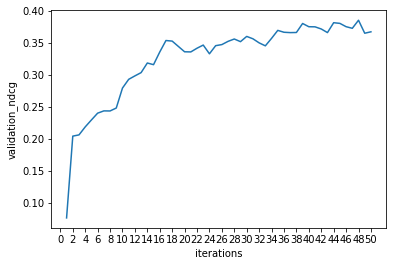

In [ ]:
def train_base_recommendation():
    losses_all=[]
    ndcgs=[]
    if gpu:
        device = torch.device('cuda:%s' % cuda)
    else:
        device = 'cpu'
    # Path(save_path).mkdir(parents=True, exist_ok=True)
    # with open(os.path.join(save_path,dataset + "_dataset_obj.pickle"), 'wb') as outp:
    #     pickle.dump(rec_dataset, outp, pickle.HIGHEST_PROTOCOL)

    train_loader = DataLoader(dataset=UserItemInterDataset(rec_dataset.training_data, 
                                rec_dataset.user_feature_matrix, 
                                rec_dataset.item_feature_matrix),
                          batch_size=batch_size,
                          shuffle=True)

    model = BaseRecModel(rec_dataset.feature_num).to(device)
    loss_fn = torch.nn.BCELoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=lr, weight_decay=weight_decay)

    out_path = os.path.join("./logs", dataset + "_logs")
    Path(out_path).mkdir(parents=True, exist_ok=True)

    ndcg = compute_ndcg(rec_dataset.test_data, 
            rec_dataset.user_feature_matrix, 
            rec_dataset.item_feature_matrix, 
            rec_k, 
            model, 
            device)
    print('init ndcg:', ndcg)
    for epoch in tqdm.trange(epochs):
        model.train()
        optimizer.zero_grad()
        losses = []
        for user_behaviour_feature, item_aspect_feature, label in train_loader:
            user_behaviour_feature = user_behaviour_feature.to(device)
            item_aspect_feature = item_aspect_feature.to(device)
            label = label.float().to(device)
            out = model(user_behaviour_feature, item_aspect_feature).squeeze()
            loss = loss_fn(out, label)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            losses.append(loss.to('cpu').detach().numpy())
            ave_train = np.mean(np.array(losses))
            losses_all.append(ave_train)
        print('epoch %d: ' % epoch, 'training loss: ', ave_train)
      
        # compute necg
        if epoch % 10 == 0:
            ndcg = compute_ndcg(rec_dataset.test_data, 
            rec_dataset.user_feature_matrix, 
            rec_dataset.item_feature_matrix, 
            rec_k, 
            model, 
            device)
            print('epoch %d: ' % epoch, 'training loss: ', ave_train, 'NDCG_validation: ', ndcg)

            ndcgs.append(ndcg)
    torch.save(model.state_dict(), os.path.join(save_path, "model.model"))
    ndcg_test = compute_ndcg(rec_dataset.test_data, 
            rec_dataset.user_feature_matrix, 
            rec_dataset.item_feature_matrix, 
            rec_k, 
            model, 
            device)
    print('\nndcg_test: ',ndcg_test)
    # plt.xlabel('iterations')
    # plt.ylabel('train_loss')
    # plt.xticks(np.arange(0,len(losses_all),100))
    # plt.plot(np.arange(0,len(losses_all)),losses_all)
    # plt.show()

    plt.xlabel('iterations')
    plt.ylabel('validation_ndcg')
    plt.xticks(np.arange(-2,len(ndcgs)+2,2))
    plt.plot(np.arange(1,len(ndcgs)+1),ndcgs)
    plt.show()
    return rec_dataset


if __name__ == "__main__":
    torch.manual_seed(0)
    np.random.seed(0)
    if gpu:
        os.environ["CUDA_VISIBLE_DEVICES"] =cuda
        print("Using CUDA",cuda)
    else:
        print("Using CPU")
    rec_dataset=train_base_recommendation()

In [ ]:
dataset="cell_phones"
base_model_path="/content/drive/MyDrive/cell_phone/"
gpu=True
cuda='0'
data_obj_path="/content/drive/MyDrive/cell_phone/"
rec_k=5
lam=100
gam=0.7
alp=0.2
user_mask=False
lr=0.005
step=1000
mask_thresh=0.3
test_num=-1
# save_path="./explanation_objs/"

In [ ]:
import torch
import pickle
import os
from pathlib import Path

# User Perspective Features

In [ ]:
import json
import nltk

In [ ]:
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
def lemmatization(text):
    result=''
    wordnet = WordNetLemmatizer()
    for token,tag in pos_tag(text):
        pos=tag[0].lower()
        if pos not in ['a', 'r', 'n', 'v']:
            pos='n'
        # if pos in ['n','a']:   
        result+=wordnet.lemmatize(token,pos)+' '
    return result
def remove_stopwords(text):
    en_stopwords = stopwords.words('english')
    en_stopwords+=['may','could','that','without','iii','with','and','This','That','Those','These','the','The','brbr','so','it','such']
    result = []
    for token in text:
        if token not in en_stopwords:
            result.append(token)
            
    return result
def remove_punct(text):
    tokenizer = RegexpTokenizer(r"\w+")
    lst=tokenizer.tokenize(' '.join(text))
    return lst

def remove_tag(text):
    text=' '.join(text)
    html_pattern = re.compile('<.*?>')
    return html_pattern.sub(r'', text)
def remove_urls(text):
    url_pattern = re.compile(r'https?://\S+|www\.\S+')
    return url_pattern.sub(r'', text)

def preprocess(text):
  chars=['&','%','#','@','^','>','<','\n','\\','\t',';','"','/']
  stwords=stopwords.words('english')
  for ch in chars:
    text=text.replace(ch,' ')
  text=" ".join(text.split())
  # text=text.lower()
  text_tokenized=word_tokenize(text)
  cleaned_text= remove_stopwords(text_tokenized)
  cleaned_text= remove_punct(cleaned_text)
  # cleaned_text=lemmatization(cleaned_text)
  cleaned_text=remove_tag(cleaned_text)
  cleaned_text=remove_urls(cleaned_text)
  cleaned_text=''.join([i for i in cleaned_text ])
  cleaned_text=[word for word in cleaned_text.split(' ') if len(word)>1]
  # print(cleaned_text)
  return ' '.join(cleaned_text)

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


In [ ]:
def preprocess_text_first(text):
  while '<' in text and '>' in text and text.index('<')<text.index('>'):
    toRemove=text[int(text.index('<')):int(text.index('>'))]+'>'
    text=text.replace(toRemove,' ')
  list_to_replace=['mso','gte','xml','false','#',',','!','-','\'','\"','[',']','/','\\n','\\','span','a-size-base','a-color-secondary','input type','header name','value','=','<a href= javascript:void(0) class= ','{','}','class=','header','<a href= javascript:void(0)','<','>','href',')','(',';','quot','&',':','javascript']
  for char in list_to_replace:
    text=text.replace(char,' ')
  for i in range(15):
    text=text.replace('  ',' ')
  # while 'if' in text and 'endif' in text and text.index('if')<text.index('endif'):
  #   # print(int(text.index('if')),int(text.index('endif')))
  #   toRemove=text[int(text.index('if')):int(text.index('endif'))]+'endif'
  #   text=text.replace(toRemove,' ')
  new_text=''
  for word in text.split(' '):
    if len(word)>1 and len(word)<35:
      new_text+=word+' '
  # new_text=lemmatization(new_text)
  # print(new_text)
  return new_text

In [ ]:
items_list=[]
users_list=[]
review_features={}
f=open('/content/drive/MyDrive/cell_phone/Cell_Phones_and_Accessories')
lines=f.readlines()
i=0
for line in lines:
  if i%5000==0:
    print(i)
  i+=1
  user_id = line.split('@')[0]
  item_id = line.split('@')[1]
  if item_id in df_meta['asin'].values:
    users_list.append(user_id)
    items_list.append(item_id)
    l = len(user_id) + len(item_id)
    fosr_data = line[l+3:]
    for seg in fosr_data.split('||'):
      if (user_id,item_id) not in review_features.keys():
        review_features[(user_id,item_id)]=[]
      fos = seg.split(':')[0].strip('|')
      if len(fos.split('|')) > 1:
            feature = fos.split('|')[0]
            opinion = fos.split('|')[1]
            sentiment = fos.split('|')[2]
            sentence= seg.split(':')[1]
            if sentiment=='+1':
              senti=1
            else:
              senti=-1
            review_features[(user_id,item_id)].append([feature,opinion,senti,sentence])

0
5000
10000
15000
20000
25000
30000
35000


In [ ]:
user_test_perspective={}
i=0
for (user_id , item_id) in review_features.keys():
  review_feature=review_features[(user_id,item_id)]
  if i%5000==0:
    print(i)
  i+=1
  for features in review_feature:
    sentence=features[3]
    sentence=preprocess_text_first(sentence)
    sentence=preprocess(sentence).lower()
    if (user_id , item_id) not in user_test_perspective.keys():
      final_vect=[]
    final_vect+=sentence.split(' ')
    for word in sentence.split(' '):
      # tokens=list(set(df_words[df_words['word']==word]['tokenized'].values))
      # for token in tokens:
        final_vect+=word.split(' ')
    final_vect=list(set(final_vect))
    new_final_vect=[]
    for word in final_vect:
      if len(word)>1:
        new_final_vect.append(word)
    user_test_perspective[(user_id , item_id)]=new_final_vect

0
5000
10000
15000


In [ ]:
user_test_perspective

In [ ]:
rec_dataset.inv_item_name_dict[622]

'B00FL6ADNC'

# Train Explaination Generator Model


In [ ]:
class ExpOptimizationModel(torch.nn.Module):
    def __init__(self, base_model, rec_dataset, device):
        super(ExpOptimizationModel, self).__init__()
        self.base_model = base_model
        self.rec_dataset = rec_dataset
        self.device = device
        self.u_i_exp_dict = {}  # {(user, item): [f1, f2, f3 ...], ...}
        self.user_feature_matrix = torch.from_numpy(self.rec_dataset.user_feature_matrix).to(self.device)
        self.item_feature_matrix = torch.from_numpy(self.rec_dataset.item_feature_matrix).to(self.device)
        self.rec_dict, self.user_perspective_test_data = self.generate_rec_dict()
        self.dict_items_cf_feature={}

    def generate_rec_dict(self):
        rec_dict = {}
        correct_rec_dict = {}  # used for user-side evaluation
        for row in self.rec_dataset.test_data:
            user = row[0]
            items = row[1]
            labels = row[2]
            correct_rec_dict[user] = []
            user_features = self.user_feature_matrix[user].repeat(len(items), 1)
            scores = self.base_model(user_features,
                        self.item_feature_matrix[items]).squeeze()
            scores = np.array(scores.to('cpu'))
            sort_index = sorted(range(len(scores)), key=lambda k: scores[k], reverse=True)
            sorted_items = [items[i] for i in sort_index]
            rec_dict[user] = sorted_items
            for i in range(rec_k):  # find the correct items and add to the user side test data
                if labels[sort_index[i]] == 1:
                    correct_rec_dict[user].append(items[sort_index[i]])

        user_perspective_test_data = {}  # {(u, i):f, (u, i): f]}
        # for user, items in correct_rec_dict.items():
        #     for item in items:
        #         user_id=rec_dataset.inv_user_name_dict[user]
        #         item_id=rec_dataset.inv_item_name_dict[item]
        #         feature = user_test_perspective[(user_id, item_id)]
        #         user_perspective_test_data[(user, item)] = feature
        return rec_dict, user_perspective_test_data
    def user_side_evaluation(self):
        ave_pre, ave_rec, ave_f1 = evaluate_user_perspective(self.user_perspective_test_data, self.u_i_exp_dict)
        print('user\'s perspective:')
        print('ave pre: ', ave_pre, '  ave rec: ', ave_rec, '  ave f1: ', ave_f1)
    
    def model_side_evaluation(self):
        ave_pn, ave_ps, ave_fns = evaluate_model_perspective(
            self.rec_dict,
            self.u_i_exp_dict,
            self.base_model,
            self.rec_dataset.user_feature_matrix,
            self.rec_dataset.item_feature_matrix,
            rec_k,
            self.dict_items_cf_feature,
            self.device)
        print('model\'s perspective:')
        print('ave PN: ', ave_pn, '  ave PS: ', ave_ps, '  ave F_{NS}: ', ave_fns)  
    def generate_explanation(self):
        # u_i_exps_dict = {}  # {(user, item): [f1, f2, f3 ...], ...}
        exp_nums = []
        exp_complexities = []
        self.no_exp_count = 0
        self.exp_count=0
        if test_num == -1:
            test_num1 = len(list(self.rec_dict.items()))
        else:
            test_num1 = test_num
        count=0
        for user, items in tqdm.tqdm(list(self.rec_dict.items())[:10]):
            count+=1
            # if count<200:
            #   continue
            # if count==2:
            #   break
            items = self.rec_dict[user]
            margin_item = items[rec_k]
            margin_score = self.base_model(self.user_feature_matrix[user].unsqueeze(0), 
                            self.item_feature_matrix[margin_item].unsqueeze(0)).squeeze()
            # print(margin_score)
            # if user_mask:
            #     # mask_vec = self.generate_mask(user)
            #     mask_vec = torch.where(self.user_feature_matrix[user]>0, 1., 0.).unsqueeze(0)  # only choose exps from the user cared aspects
            # else:
                
            for item in items[: rec_k]:
                item_id=rec_dataset.inv_item_name_dict[item]
                tensor_vect_desc,tensor_vect_title,tensor_vect_feature=get_tensor_vects(item_id)
                self.dict_items_cf_feature[item]=(tensor_vect_desc,tensor_vect_title,tensor_vect_feature)
                # print(tensor_vect_desc.shape)
                # print(tensor_vect_title.shape)
                # print(tensor_vect_feature.shape)
                explanation_features,explanation_features_words, exp_num, exp_complexity = self.explain(user,item,
                    self.user_feature_matrix[user], 
                    self.item_feature_matrix[item], 
                    margin_score,
                    tensor_vect_desc,tensor_vect_title,tensor_vect_feature)
                
                if explanation_features is None:
                    # print('no explanation for user %d and item %d' % (user, item))
                    self.no_exp_count += 1
                else:
                    self.exp_count+=1
                    self.u_i_exp_dict[(user, item)] = explanation_features_words
                    # print(explanation_features_words)
                    exp_nums.append(exp_num)
                    exp_complexities.append(exp_complexity)
            # if count%500==0:
            #   json1 = json.dumps(self.u_i_exp_dict)
            #   f = open("drive/MyDrive/ranjbar/dict{}.json".format(count),"w")
            #   f.write(json1)
            #   f.close()

              
        print('ave num: ', np.mean(exp_nums), 'ave complexity: ', np.mean(exp_complexities) , 'no_exp_count: ', self.no_exp_count, 'exp_count: ', self.exp_count)
        return True
    
    def explain(self,user,item, user_feature, item_feature, margin_score,tensor_vect_desc,tensor_vect_title,tensor_vect_feature):
        exp_generator = EXPGenerator(
            self.rec_dataset, 
            self.base_model, 
            user_feature, 
            item_feature, 
            user,
            item,
            margin_score,
            tensor_vect_desc,tensor_vect_title,tensor_vect_feature, 
            self.device).to(self.device)

        # optimization
        optimizer = torch.optim.SGD(exp_generator.parameters(), lr=lr, weight_decay=0)
        exp_generator.train()
        lowest_loss = None
        lowest_bpr = None
        lowest_l2 = 0
        optimize_delta = None
        score = exp_generator()
        # print(score)
        bpr, l2, l1, loss = exp_generator.loss(score)
        # print('init: ', 0, '  train loss: ', loss, '  bpr: ', bpr, '  l2: ', l2, '  l1: ', l1)
        lowest_loss = loss
        lowest_bpr=bpr
        optimize_delta = exp_generator.delta.detach().to('cpu').numpy()
        optimize_weights=exp_generator.weights.detach().to('cpu').numpy()
        lowest_l2 = l2
        for epoch in range(step):
            exp_generator.zero_grad()
            score = exp_generator()
            bpr, l2, l1, loss = exp_generator.loss(score)

            # if epoch %100 == 0:
            #     print(
            #         'epoch', epoch,
            #         'bpr: ', bpr,
            #         'l2: ', l2,
            #         'l1', l1,
            #         'loss', loss)

            loss.backward()
            optimizer.step()
            if loss < lowest_loss:
                lowest_loss = loss
                lowest_l2 = l2
                lowest_bpr = bpr
                optimize_delta = exp_generator.delta.detach().to('cpu').numpy()
                optimize_weights=exp_generator.weights.detach().to('cpu').numpy()
        # print(lowest_bpr)
        # print(lam * alp)
        # print(optimize_delta)
        if lowest_bpr >= lam * alp:
            explanation_features = None 
            exp_num = None
            exp_complexity = None
            explanation_features_words=None
        else:
            # optimize_delta = exp_generator.delta.detach().to('cpu').numpy()
            # print(optimize_delta)
            # explanation_features = np.argwhere(optimize_delta < - mask_thresh).squeeze(axis=1)
            explanation_features = np.argwhere(optimize_weights <  mask_thresh).squeeze(axis=1)
            # print(optimize_weights)
            
            # print(explanation_features)
            if len(explanation_features) == 0:
                explanation_features = np.array([np.argmin(optimize_weights)])
            explanation_features_words=list(set([exp_generator.features[i] for i in explanation_features]))
            # print(explanation_features_words)
            # print('-------------\n')
            new_vect=[]
            for word in explanation_features_words:
              new_vect+=(str(word).split(' '))
            new_vect=list(set(new_vect))
            new_vect=[word for word in new_vect if len(word)>1]
            explanation_features_words=new_vect
            exp_num = len(explanation_features_words)
            exp_complexity = lowest_l2.to('cpu').detach().numpy() + gam * exp_num
        return explanation_features,explanation_features_words, exp_num, exp_complexity
    


In [ ]:
def get_tensor_vect_df(df,not_in_columns):
  df['main_word']=np.where(df['replaced_word'] == df[not_in_columns],1,0)
  df=df[df['main_word']==1]
  lists=df.loc[:, ~df.columns.isin([not_in_columns,'replaced_word','logit','main_word'])].values
  words=df[not_in_columns].values
  # print(words)
  vects=[sub_list[0] for sub_list in lists]
  tensor_vect=torch.FloatTensor(vects).to(device)
  return tensor_vect

In [ ]:
def get_tensor_vects(item_id):
  tensor_vect_desc=None
  tensor_vect_title=None
  tensor_vect_feature=None
  if os.path.exists(save_path+'description_bert/'+'df_bert_desc_{}.json'.format(item_id)) :
      df_vect_desc= pd.read_json(save_path+'description_bert/'+'df_bert_desc_{}.json'.format(item_id))
      # df_vect_desc=df_vect[0]
      tensor_vect_desc=get_tensor_vect_df(df_vect_desc,'description_words')

      df_vect_title= pd.read_json(save_path+'title_bert/'+'df_bert_title_{}.json'.format(item_id))
      # df_vect_title=df_vect[1]
      tensor_vect_title=get_tensor_vect_df(df_vect_title,'title_words')

      df_vect_feature= pd.read_json(save_path+'feature_bert/'+'df_bert_feature_{}.json'.format(item_id))
      # df_vect_feature=df_vect[2]
      tensor_vect_feature=get_tensor_vect_df(df_vect_feature,'feature_words')
      # print(tensor_vect_feature)
  # print(tensor_vect_desc)
  return tensor_vect_desc,tensor_vect_title,tensor_vect_feature

In [ ]:
normalized_rank=get_normalized_rank(df_meta)

In [ ]:
df_meta[df_meta['asin']=='B0006TIA8Y']

,Unnamed: 0,description,title,feature,rank,price,asin
207,2679,['The CyberPower CPH320AP Charging Dock and 3-...,CyberPower CPH320AP Charging Dock and 3 Port U...,"['iPod / iPhone 3G, 3GS, 4, 4S Charging Dock',...","['>#718,144 in Cell Phones & Accessories (See ...",$4.00,B0006TIA8Y


In [ ]:
rec_dataset.inv_item_name_dict

In [ ]:
def get_features(item):
  item_features=rec_dataset.item_features[item]
  len_features=0
  features=[]
  # print(item)
  # print(item_features)
  for i in range(3):
    len_features+=len(item_features[i])
    features+=item_features[i]
  # for key in item_features[3]:
  #   len_features+=len(item_features[3][key])
  #   features+=item_features[3][key]
  # features+=item_features[3]
  # len_features+=1
  return len_features,features

In [ ]:
def get_new_item_vector(item,item_feature_name,new_weights,tensor_vect_desc,tensor_vect_title,tensor_vect_feature):
    # item_id= rec_dataset.inv_item_name_dict[item]
    final_vector=[]
    # print(len(new_weights))
    # print(len(item_feature_name[0]))
    # print(tensor_vect_desc.shape)
    average_vect_desc=get_average_vect_test(new_weights[0:len(item_feature_name[0])],tensor_vect_desc)
    average_vect_title=get_average_vect_test(new_weights[len(item_feature_name[0]):len(item_feature_name[0])+len(item_feature_name[1])],tensor_vect_title)
    average_vect_feature=get_average_vect_test(new_weights[len(item_feature_name[0])+len(item_feature_name[1]):],tensor_vect_feature)
    # rank=normalized_rank[item_id]*new_weights[-1]
    final_vector=torch.cat((average_vect_desc,average_vect_title,average_vect_feature))
    # print(len(final_vector))
    # final_vect=np.array(final_vector, dtype='float32')
    return final_vector

In [ ]:
torch.reshape(normalized_rank[item_id]*torch.tensor(0.5),(1,))

tensor([4.7803e-05])

In [ ]:
class EXPGenerator(torch.nn.Module):
    def __init__(self, rec_dataset, base_model, user_vect, item_vect,user,item, margin_score,tensor_vect_desc,tensor_vect_title,tensor_vect_feature, device):
        super(EXPGenerator, self).__init__()
        self.rec_dataset = rec_dataset
        self.base_model = base_model
        self.user_vect = user_vect
        self.item_vect= item_vect
        self.margin_score = margin_score
        self.device = device
        self.feature_length,self.features=get_features(item)
        # print(self.features)
        self.item=item
        self.user=user
        self.tensor_vect_desc=tensor_vect_desc
        self.tensor_vect_title=tensor_vect_title
        self.tensor_vect_feature=tensor_vect_feature
        # self.feature_range = [0, 1]  # hard coded, should be improved later
        self.delta_range = 1  # the maximum feature value.
        self.delta = torch.nn.Parameter(
            torch.FloatTensor(self.feature_length).uniform_(-self.delta_range, 0))
        self.ws=torch.ones(self.feature_length).to(device)
    
    def get_masked_item_feature(self):
        item_feature_name=self.rec_dataset.item_features[self.item]
        # print(item_feature_name)
        self.weights=(self.ws+ torch.clamp((self.delta), -self.delta_range,0))
        # new_weights= 1.0/(1.0+torch.exp(-3.0*new_weights))
        # new_weights= torch.where(new_weights>=0.5 , 1.0 , 0.0)
        # new_weights=torch.tensor(new_weights , dtype= torch.float)
        # print(len(self.weights))
        item_feature_star=get_new_item_vector(self.item,item_feature_name,self.weights,self.tensor_vect_desc,self.tensor_vect_title,self.tensor_vect_feature)
        # print(item_feature_star)
        return item_feature_star
    
    def forward(self):
        item_feature_star = self.get_masked_item_feature()
        # print(item_feature_star.unsqueeze(0).shape)
        # print(self.user_vect.unsqueeze(0).shape)
        score = self.base_model(self.user_vect.unsqueeze(0), item_feature_star.unsqueeze(0))
        # print(score)
        return score
    
    def loss(self, score):
        # print(score - self.margin_score)
        bpr = torch.nn.functional.relu(alp + score - self.margin_score) * lam
        # print(score - self.margin_score)
        l2 = torch.linalg.norm(self.delta)
        # num_removed= 1.0/(1.0+torch.exp(-1.0*self.delta))
        # num_removed=torch.tensor(num_removed , dtype= torch.float)
        # print(num_removed)
        l1 = torch.linalg.norm(self.delta, ord=1) * gam
        loss =  bpr +l1
        return bpr, l2, l1, loss

In [ ]:
with open(os.path.join(data_obj_path, dataset + "_dataset_obj.pickle"), 'rb') as inp:
  rec_dataset = pickle.load(inp)

In [ ]:
user_test_perspective

In [ ]:
def evaluate_user_perspective(user_perspective_data, u_i_expl_dict):
    pres = []
    recs = []
    f1s = []
    for u_i, gt_features in user_perspective_data.items():
        if u_i in u_i_expl_dict:
            TP = 0
            pre_features = u_i_expl_dict[u_i]
            # print('f: ', gt_features, pre_features)
            for feature in pre_features:
                if feature in gt_features:
                    TP += 1
            # print(gt_features)
            # print(pre_features)
            pre = TP / len(pre_features)
            rec = TP / len(gt_features)
            if (pre + rec) != 0:
                f1 = (2 * pre * rec) / (pre + rec)
            else:
                f1 = 0
            pres.append(pre)
            recs.append(rec)
            f1s.append(f1)
    ave_pre = np.mean(pres)
    ave_rec = np.mean(recs)
    ave_f1 = np.mean(f1s)
    return ave_pre, ave_rec, ave_f1

In [ ]:
def evaluate_model_perspective(
        rec_dict,
        u_i_exp_dict,
        base_model,
        user_feature_matrix,
        item_feature_matrix,
        rec_k,
        dict_items_cf_feature,
        device):
    """
    compute PN, PS and F_NS score for the explanations
    :param rec_dict: {u1: [i1, i2, i3, ...] , u2: [i1, i2, i3, ...]}
    :param u_i_exp_dict: {(u, i): [f1, f2, ...], ...}
    :param base_model: the trained base recommendation model
    :param user_feature_matrix: |u| x |p| matrix, the attention on each feature p for each user u
    :param item_feature_matrix: |i| x |p| matrix, the quality on each feature p for each item i
    :param rec_k: the length of the recommendation list, only generated explanations for the items on the list
    :param device: the device of the model
    :return: the mean of the PN, PS and FNS scores
    """
    pn_count = 0
    ps_count = 0
    # df_vects=rec_dataset.df_vects
    # print(len( u_i_exp_dict))
    i=0
    for u_i, fs in u_i_exp_dict.items():
        user = u_i[0]
        target_item = u_i[1]
        features = set(fs)
        items = rec_dict[user]
        target_index = items.index(target_item)
        features=list(features)
        if i%50==0:
          print(i)
        i+=1
        # print(len(items))
        # print(features)
        # compute PN
        cf_items_features1 = []
        cf_items_features2 = []
        for item in items:
            # print(item)
            # item_ori_feature = np.array(item_feature_matrix[item])
            item_id=rec_dataset.inv_item_name_dict[item]
            len_features,all_features=get_features(item)
            # print(all_features)
            item_feature_name=rec_dataset.item_features[item]
            weights1=[0.0 if fea in features else 1.0 for fea in all_features]
            weights2=[1.0 if fea in features else 0.0 for fea in all_features]
            weights1=torch.from_numpy(np.array(weights1,dtype='float32')).to(device)
            weights2=torch.from_numpy(np.array(weights2,dtype='float32')).to(device)
            # print(len(all_features))
            # print(all_features)
            # weights=torch.FloatTensor(weights).to(device)
            if item in dict_items_cf_feature.keys():
              tensor_vect_desc,tensor_vect_title,tensor_vect_feature=dict_items_cf_feature[item]
            else:
              tensor_vect_desc,tensor_vect_title,tensor_vect_feature=get_tensor_vects(item_id)
              dict_items_cf_feature[item]=(tensor_vect_desc,tensor_vect_title,tensor_vect_feature)
            
            item_cf_feature1=get_new_item_vector(item,item_feature_name,weights1,tensor_vect_desc,tensor_vect_title,tensor_vect_feature).detach().to('cpu').numpy()
            item_cf_feature2=get_new_item_vector(item,item_feature_name,weights2,tensor_vect_desc,tensor_vect_title,tensor_vect_feature).detach().to('cpu').numpy()
            cf_items_features1.append(item_cf_feature1)
            cf_items_features2.append(item_cf_feature2)
            # print(item_cf_feature)
            # print(torch.from_numpy(np.array(cf_items_features,dtype='float32')).to(device))
            # print(np.shape(item_cf_feature))
            # print(np.shape(cf_items_features))
        # print(np.shape(cf_items_features))
        cf_ranking_scores1 = base_model(torch.from_numpy(np.array([user_feature_matrix[user]
                                                                      for i in range(len(cf_items_features1))])
                                                            ).to(device),
                                           torch.from_numpy(np.array(cf_items_features1,dtype='float32')).to(device)).squeeze()
        cf_score_list1 = cf_ranking_scores1.to('cpu').detach().numpy()
        sorted_index1 = np.argsort(cf_score_list1)[::-1]
        cf_rank1 = np.argwhere(sorted_index1 == target_index)[0, 0]  # the updated ranking of the current item
        if cf_rank1 > rec_k - 1:
            pn_count += 1
        # compute NS
        cf_ranking_scores2 = base_model(torch.from_numpy(np.array([user_feature_matrix[user]
                                                                      for i in range(len(cf_items_features2))])
                                                            ).to(device),
                                           torch.from_numpy(np.array(cf_items_features2,dtype='float32')).to(device)).squeeze()
        cf_score_list2 = cf_ranking_scores2.to('cpu').detach().numpy()
        sorted_index2 = np.argsort(cf_score_list2)[::-1]
        cf_rank2 = np.argwhere(sorted_index2 == target_index)[0, 0]  # the updated ranking of the current item
        if cf_rank2 < rec_k:
            ps_count += 1
    if len(u_i_exp_dict) != 0:
        pn = pn_count / len(u_i_exp_dict)
        ps = ps_count / len(u_i_exp_dict)
        if (pn + ps) != 0:
            fns = (2 * pn * ps) / (pn + ps)
        else:
            fns = 0
    else:
        pn = 0
        ps = 0
        fns = 0
    return pn, ps, fns

In [ ]:
with open(os.path.join(data_obj_path, dataset + "_dataset_obj.pickle"), 'rb') as inp:
   rec_dataset = pickle.load(inp)

In [ ]:
def generate_explanation():
    if gpu:
        device = torch.device('cuda:%s' %cuda)
    else:
        device = 'cpu'
    print(device)
    # import dataset
    with open(os.path.join(data_obj_path, dataset + "_dataset_obj.pickle"), 'rb') as inp:
        rec_dataset = pickle.load(inp)
    base_model = BaseRecModel(rec_dataset.feature_num).to(device)
    base_model.load_state_dict(torch.load(os.path.join(base_model_path,"model.model"),map_location=torch.device(device)))
    base_model.eval()
    #  fix the rec model
    for param in base_model.parameters():
        param.requires_grad = False
    
    # Create optimization model
    opt_model = ExpOptimizationModel(
        base_model=base_model,
        rec_dataset=rec_dataset,
        device = device,
          
    )

    opt_model.generate_explanation()
    Path(save_path).mkdir(parents=True, exist_ok=True)
    with open(os.path.join(save_path, dataset + "_explanation_obj.pickle"), 'wb') as outp:
        pickle.dump(opt_model, outp, pickle.HIGHEST_PROTOCOL)
    # with open(os.path.join(save_path, dataset + "_explanation_obj.pickle"), 'rb') as opt:
    #     opt_model = pickle.load(opt)
    opt_model.user_side_evaluation()
    opt_model.model_side_evaluation()
    # print(opt_model.u_i_exp_dict)
    # Path(save_path).mkdir(parents=True, exist_ok=True)
    # with open(os.path.join(save_path, dataset + "_explanation_obj.pickle"), 'wb') as outp:
    #     pickle.dump(opt_model, outp, pickle.HIGHEST_PROTOCOL)
    return opt_model


if __name__ == "__main__":
    opt_model=generate_explanation()

cuda:0


100%|██████████| 93/93 [21:07<00:00, 13.62s/it]


ave num:  6.05 ave complexity:  6.6784915779077485 no_exp_count:  5 exp_count:  460
user's perspective:
ave pre:  0.10757709675533568   ave rec:  0.04972605084382754   ave f1:  0.05718869502040338
0
50
100
150
200
250
300
350
400
450
model's perspective:
ave PN:  0.9152173913043479   ave PS:  0.9717391304347827   ave F_{NS}:  0.9426317371268282


In [ ]:
with open(os.path.join(save_path, dataset + "_explanation_obj_main.pickle"), 'rb') as opt:
  opt_model = pickle.load(opt)

In [ ]:
user_id=opt_model.rec_dataset.inv_user_name_dict[58]
user_id

'A1F7YU6O5RU432'

In [ ]:
item_id=opt_model.rec_dataset.inv_item_name_dict[1464]
item_id

'B00Z7RQ0NC'

In [ ]:
df_meta[df_meta['asin']==item_id]['description'].values[0]

"['Color:DATE NIGHT (BLACK/WHITE POLKA DOT GRAPHIC) | Product Packaging:Retail Packaging When it comes to your iPhone 8 Plus & iPhone 7 Plus, its not just about protection. Its also about you  your style, your personality, your life. With Symmetry Series, you dont have to choose between a protective case and a stylish one. You can make a fashion statement while you protect your phone.']"

In [ ]:
df_meta[df_meta['asin']==item_id]['feature'].values[0]

"['Compatible with iPhone 8 Plus & iPhone 7 Plus (ONLY)', 'Thin, sleek, stylish, pocket-friendly design, with wraparound colors and graphics add seamless style.', 'Dual-material construction absorbs shock and withstands drops, plus raised beveled edge keeps your touchscreen safe.', 'Easy installation protects and stylizes your phone in a flash.', 'Includes OtterBox limited lifetime warranty (see website for details) and 100% authentic.']"

In [ ]:
df_meta[df_meta['asin']==item_id]['title'].values[0]

'OtterBox SYMMETRY SERIES Case for  iPhone 8 Plus &amp; iPhone 7 Plus (ONLY)  - DATE NIGHT (BLACK/WHITE POLKA DOT GRAPHIC)'

In [ ]:
opt_model.rec_dataset

In [ ]:
opt_model.rec_dataset.test_data

# Calculate Stability ...

In [ ]:
def generate_explanation_check_stability():
    if gpu:
        device = torch.device('cuda:%s' %cuda)
    else:
        device = 'cpu'
    print(device)
    with open(os.path.join(data_obj_path, dataset + "_dataset_obj.pickle"), 'rb') as inp:
        rec_dataset = pickle.load(inp)
    base_model = BaseRecModel(rec_dataset.feature_num).to(device)
    base_model.load_state_dict(torch.load(os.path.join(base_model_path,"model.model"),map_location=torch.device(device)))
    base_model.eval()
    #  fix the rec model
    for param in base_model.parameters():
        param.requires_grad = False
    
    
    # Create optimization model
    features_found=[]
    for i in range(10):
      opt_model = ExpOptimizationModel(
        base_model=base_model,
        rec_dataset=rec_dataset,
        device = device,)
      opt_model.generate_explanation()
      features_found.append(opt_model.u_i_exp_dict)
      
    
    return features_found


if __name__ == "__main__":
    features_found=generate_explanation_check_stability()

cuda:0


100%|██████████| 10/10 [03:44<00:00, 22.43s/it]


ave num:  4.72 ave complexity:  5.463916503429413 no_exp_count:  0 exp_count:  50


100%|██████████| 10/10 [01:24<00:00,  8.42s/it]


ave num:  4.84 ave complexity:  5.555135503292082 no_exp_count:  0 exp_count:  50


100%|██████████| 10/10 [01:23<00:00,  8.37s/it]


ave num:  4.74 ave complexity:  5.4799079279899585 no_exp_count:  0 exp_count:  50


100%|██████████| 10/10 [01:23<00:00,  8.35s/it]


ave num:  4.84 ave complexity:  5.549920747756956 no_exp_count:  0 exp_count:  50


100%|██████████| 10/10 [01:24<00:00,  8.40s/it]


ave num:  4.82 ave complexity:  5.53976008439064 no_exp_count:  0 exp_count:  50


100%|██████████| 10/10 [01:23<00:00,  8.34s/it]



ave num:  4.9 ave complexity:  5.601808297634124 no_exp_count:  0 exp_count:  50
ave num:  4.9 ave complexity:  5.601808297634124 no_exp_count:  0 exp_count:  50


100%|██████████| 10/10 [01:23<00:00,  8.40s/it]



ave num:  4.76 ave complexity:  5.494335857152938 no_exp_count:  0 exp_count:  50
ave num:  4.76 ave complexity:  5.494335857152938 no_exp_count:  0 exp_count:  50


100%|██████████| 10/10 [01:24<00:00,  8.45s/it]



ave num:  4.68 ave complexity:  5.43424874639511 no_exp_count:  0 exp_count:  50
ave num:  4.68 ave complexity:  5.43424874639511 no_exp_count:  0 exp_count:  50


100%|██████████| 10/10 [01:24<00:00,  8.43s/it]



ave num:  4.94 ave complexity:  5.6281217162609085 no_exp_count:  0 exp_count:  50
ave num:  4.94 ave complexity:  5.6281217162609085 no_exp_count:  0 exp_count:  50


100%|██████████| 10/10 [01:24<00:00,  8.42s/it]

ave num:  4.84 ave complexity:  5.552221096038817 no_exp_count:  0 exp_count:  50
ave num:  4.84 ave complexity:  5.552221096038817 no_exp_count:  0 exp_count:  50


In [ ]:
dict_features={}
for iter_feas in features_found:
  for u_i in iter_feas.keys():
    # feas=list(iter_feas[u_i][0][0].columns)
    feas=iter_feas[u_i]
    # print(iter_feas[u_i])
    if u_i in dict_features.keys():
      dict_features[u_i].append(feas)
    else:
      dict_features[u_i]=[]
      dict_features[u_i].append(feas)

In [ ]:
dict_features

{(6, 1810): [['speck', 'grade', 'galaxy', 'samsung', 'military', 'edge'],
  ['speck', 'grade', 'galaxy', 'samsung', 'military', 'edge'],
  ['speck', 'grade', 'galaxy', 'samsung', 'military', 'edge'],
  ['speck', 'grade', 'galaxy', 'samsung', 'military', 'edge'],
  ['speck', 'grade', 'galaxy', 'samsung', 'military', 'edge'],
  ['speck', 'grade', 'galaxy', 'samsung', 'military', 'edge'],
  ['speck', 'grade', 'galaxy', 'samsung', 'military', 'edge'],
  ['speck', 'grade', 'galaxy', 'samsung', 'military', 'edge'],
  ['speck', 'grade', 'galaxy', 'samsung', 'military', 'edge'],
  ['speck', 'grade', 'galaxy', 'samsung', 'military', 'edge']],
 (6,
  1847): [['voice',
   'exclusively',
   'phones',
   'car',
   'android',
   'assistant',
   'zerotouch',
   'mount',
   'amazon',
   'hands',
   'logitech',
   'alexa',
   'free'], ['voice',
   'exclusively',
   'phones',
   'car',
   'android',
   'assistant',
   'zerotouch',
   'mount',
   'amazon',
   'hands',
   'logitech',
   'alexa',
   'free'

In [ ]:
stability=0
# count_all=0
for ui in dict_features.keys():
  features=dict_features[ui]
  stabs=0
  count=0
  if(len(features)>1):
    # count_all+=1
    for i in range(len(features)):
      for j in range(len(features)):
        # print(features[i])
        # print(features[j])
        if len(features[i])>0 and len(features[j])>0:
          if i != j:
            intersection = list(set(features[i]) & set(features[j]))
            union = list(set(features[i]) | set(features[j]))
            # print(features[i],features[j])
            # print(intersection)
            # print(union)
            count+=1
            stabs+=(len(intersection)/len(union))
    # print(stabs)
    # print(len(features)*(len(features)-1))
    # print((stabs/(len(features)*(len(features)-1))))
    stability+=(stabs/(9.0*10.0))

stability=stability/len(dict_features)
print(stability)

0.8621740065706299
